<h1 style = "text-align:center; font-size:300%">Walmart Store Sales Prediction</h1>

---

## Description (Business Problem):

One of the leading retail stores in the US, Walmart, would like to predict the sales and demand accurately. There are certain events and holidays which impact sales on each day. There are sales data available for 45 stores of Walmart. The business is facing a challenge due to unforeseen demands and runs out of stock some times, due to the inappropriate machine learning algorithm. An ideal ML algorithm will predict demand accurately and ingest factors like economic conditions including CPI, Unemployment Index, etc.

Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of all, which are the Super Bowl, Labour Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data. Historical sales data for 45 Walmart stores located in different regions are available.


## About Dataset:
This is the historical data that covers sales from 2010-02-05 to 2012-11-01, in the file Walmart_Store_sales. Within this file you will find the following fields:
* Store - the store number
* Date - the week of sales
* Weekly_Sales -  sales for the given store
* Holiday_Flag - whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week
* Temperature - Temperature on the day of sale
* Fuel_Price - Cost of fuel in the region
* CPI – Prevailing consumer price index
* Unemployment - Prevailing unemployment rate
* Holiday Events\
Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13\
Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13\
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13\
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13



## Objectives:
- Understand the Dataset & cleanup (if required).
- Build Regression models to predict the sales.
- Evaluate the models & compare their respective scores.

---

# Importing Libraries

In [2]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 639.4 kB/s eta 0:00:00


In [3]:
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy import stats

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings('ignore')

plt.style.use(style='fivethirtyeight')
%matplotlib inline


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

---

# Loading & Inspecting Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/All Projects/Machine Learning With Python/Walmart Store Sales Prediction/Walmart_data.csv')
# data = pd.read_csv('/kaggle/input/walmart-dataset/Walmart.csv')

In [6]:
data.head()

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

In [7]:
# some information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [8]:
# change float format in data
pd.options.display.float_format = '{:,.0f}'.format

In [9]:
# data distribution
data.describe().round(2)

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price   CPI  \
count  6,435         6,435         6,435        6,435       6,435 6,435   
mean      23     1,046,965             0           61           3   172   
std       13       564,367             0           18           0    39   
min        1       209,986             0           -2           2   126   
25%       12       553,350             0           47           3   132   
50%       23       960,746             0           63           3   183   
75%       34     1,420,159             0           75           4   213   
max       45     3,818,686             1          100           4   227   

       Unemployment  
count         6,435  
mean              8  
std               2  
min               4  
25%               7  
50%               8  
75%               9  
max              14

---

# Data Preperation

## 1. Rename Columns

In [10]:
# rename columns
data.columns  = data.columns.str.lower()
data.rename({'holiday_flag': 'is_holiday'}, axis = 1, inplace = True)
data.columns

Index(['store', 'date', 'weekly_sales', 'is_holiday', 'temperature',
       'fuel_price', 'cpi', 'unemployment'],
      dtype='object')

## 2. Missing Values

In [11]:
# cheak missing values
data.isnull().sum()

store           0
date            0
weekly_sales    0
is_holiday      0
temperature     0
fuel_price      0
cpi             0
unemployment    0
dtype: int64

**Conclusion:**

- The dataset doesn't have any missing values

## 3. Duplicate Values

In [12]:
# Check Duplicate Values
data.duplicated().sum()

0

**Conclusion:**

- The dataset doesn't have any duplicate values

## 4. Feature Engineering

In [13]:
def get_season(quarter):

    '''this function is to get season according to quarter column'''

    if quarter == 1:
        return 'Winter'
    elif quarter == 2:
        return 'Spring'
    elif quarter == 3:
        return 'Summer'
    else:
        return 'Autumn'

In [47]:
# correct data format of the 'date' column
data['date'] = pd.to_datetime(data['date'], format = "%d-%m-%Y")

# Create a new column "year" containing the year
data['year'] = data['date'].dt.year

# Create a new column "quarter" containing the season number
data['quarter'] = data['date'].dt.quarter

# Create a new column "season" containing the season
data['season'] = data['quarter'].apply(get_season)

# Create a new column "month" containing the month number
data['month'] = data['date'].dt.month

# Create a new column "month_name" containing the month names
data['month_name'] = data['date'].dt.month_name()

# Create a new column "week" containing the week number
data['week'] = data['date'].dt.isocalendar().week

# Create a new column "day_of_week" containing the day names
data['day_of_week'] = data['date'].dt.day_name()

In [15]:
# display a data sample
data.head(5)

store       date  weekly_sales  is_holiday  temperature  fuel_price  cpi  \
0      1 2010-02-05     1,643,691           0           42           3  211   
1      1 2010-02-12     1,641,957           1           39           3  211   
2      1 2010-02-19     1,611,968           0           40           3  211   
3      1 2010-02-26     1,409,728           0           47           3  211   
4      1 2010-03-05     1,554,807           0           46           3  211   

   unemployment  year  quarter  season month_name  week day_of_week  
0             8  2010        1  Winter   February     5      Friday  
1             8  2010        1  Winter   February     6      Friday  
2             8  2010        1  Winter   February     7      Friday  
3             8  2010        1  Winter   February     8      Friday  
4             8  2010        1  Winter      March     9      Friday

In [52]:
data['week'] = data['week'].astype('int32')

---

# Exploratory Data Analysis (EDA)

* Univariate Analysis
* Bi-variate Analysis
* Time Series Analysis

## Univariate Analysis

### 1. Numerical Features

- weekly_sales
- temperature
- fuel_price
- unemployment
- cpi

In [17]:
data[['weekly_sales', 'temperature', 'fuel_price', 'unemployment', 'cpi']].describe()

weekly_sales  temperature  fuel_price  unemployment   cpi
count         6,435        6,435       6,435         6,435 6,435
mean      1,046,965           61           3             8   172
std         564,367           18           0             2    39
min         209,986           -2           2             4   126
25%         553,350           47           3             7   132
50%         960,746           63           3             8   183
75%       1,420,159           75           4             9   213
max       3,818,686          100           4            14   227

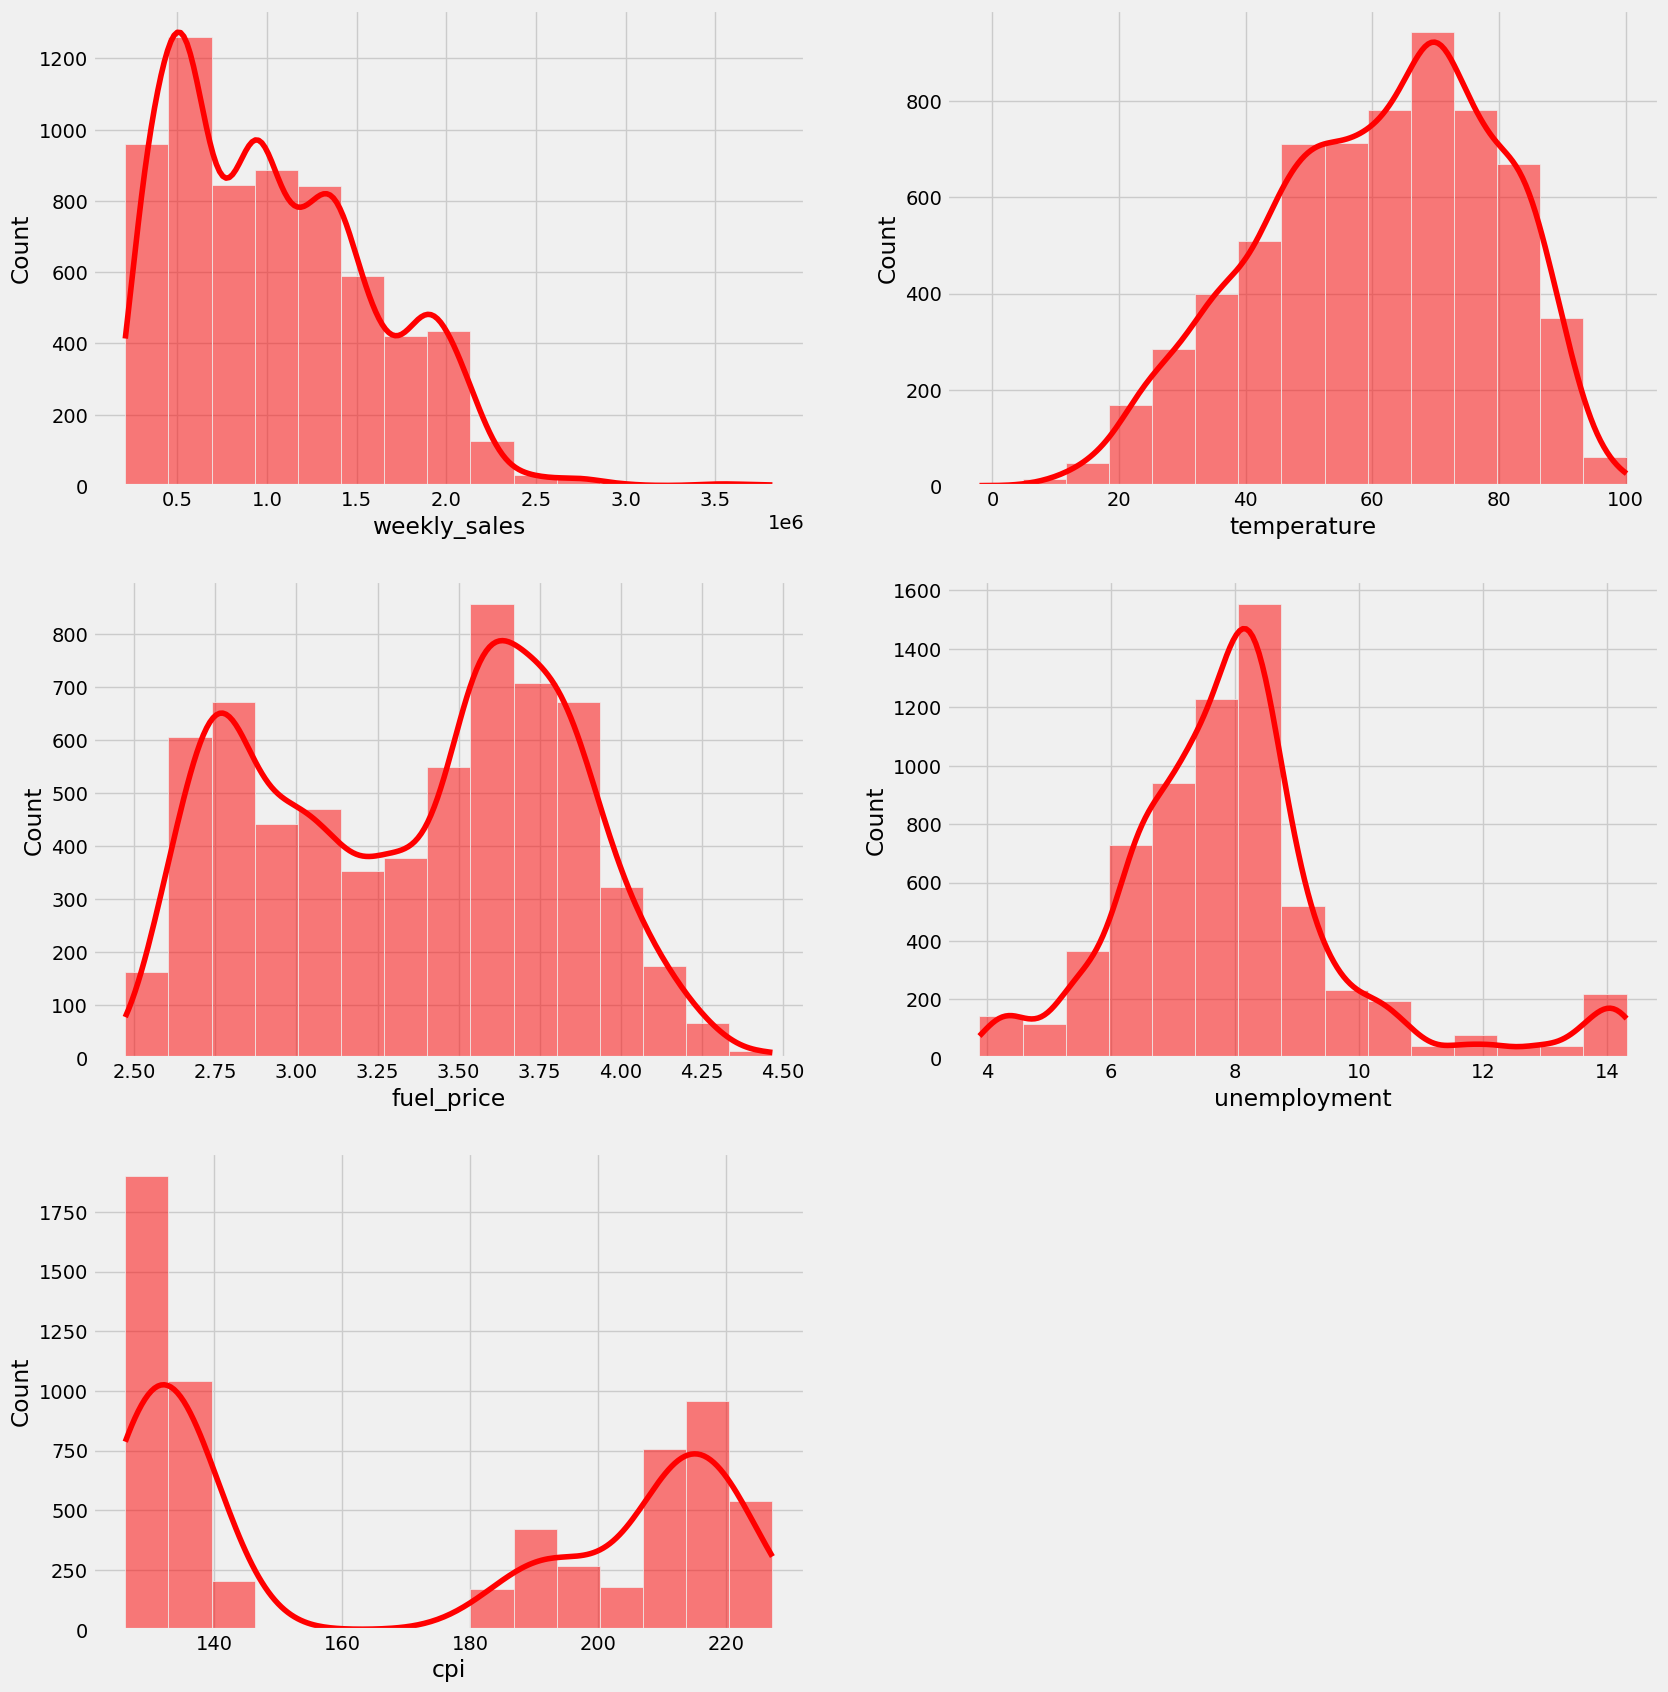

In [18]:
columns = ['weekly_sales', 'temperature', 'fuel_price', 'unemployment', 'cpi']
plt.figure(figsize=(18, 20))
for i,col in enumerate(columns):
    plt.subplot(3, 2, i+1)
    sns.histplot(data = data, x = col, kde = True, bins = 15, color = 'r')
plt.show()

**Conclusion:**

- The distribution of Weekly_Sales is right skewed, this is normal because the weekly sales may be high in some time.
- Temperature and Unemployment have normal distribution.
- CPI and Fuel_Price have bimodal distribution.

### 2. categorical Features

- is_holiday
- year
- season
- month_name
- day_of_week

### 2.1. is_holiday

In [19]:
d = data['is_holiday'].value_counts()
d

0    5985
1     450
Name: is_holiday, dtype: int64

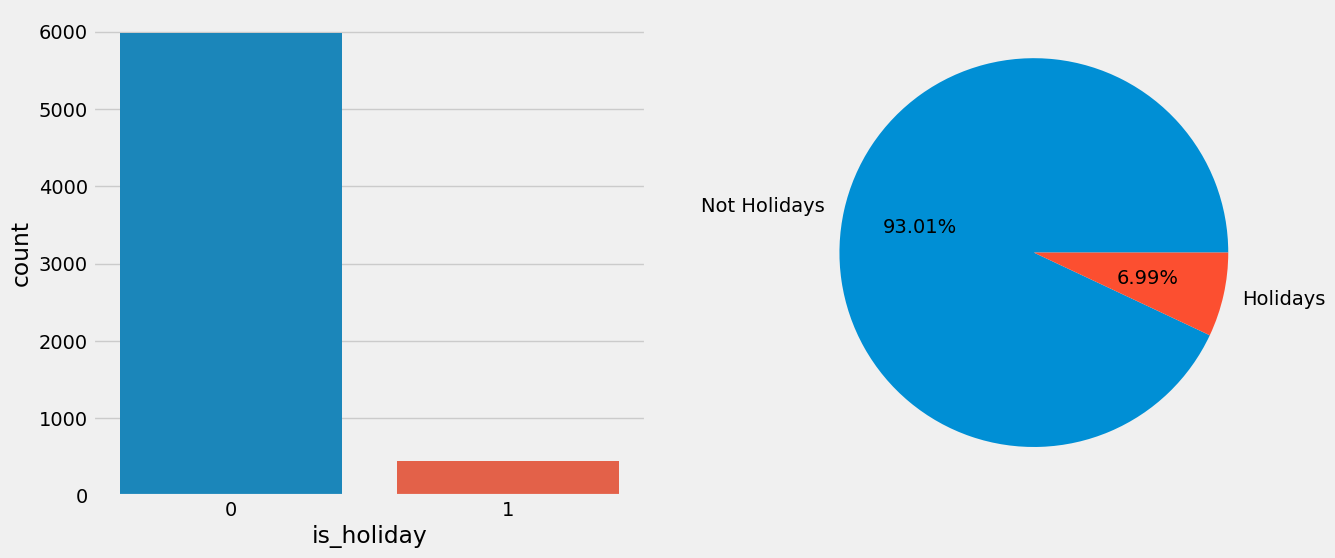

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
sns.countplot(data = data, x = 'is_holiday', ax = ax[0])

ax[1].pie(data['is_holiday'].value_counts().values,
          labels = ['Not Holidays', 'Holidays'],
          autopct = '%1.2f%%')

plt.show()

**Conclusion:**

- Days of no holiday are the most frequent than days of holiday in the dataset with a percentage of 93 % and this is normal.

### 2.2. year

In [21]:
data['year'].value_counts()

2011    2340
2010    2160
2012    1935
Name: year, dtype: int64

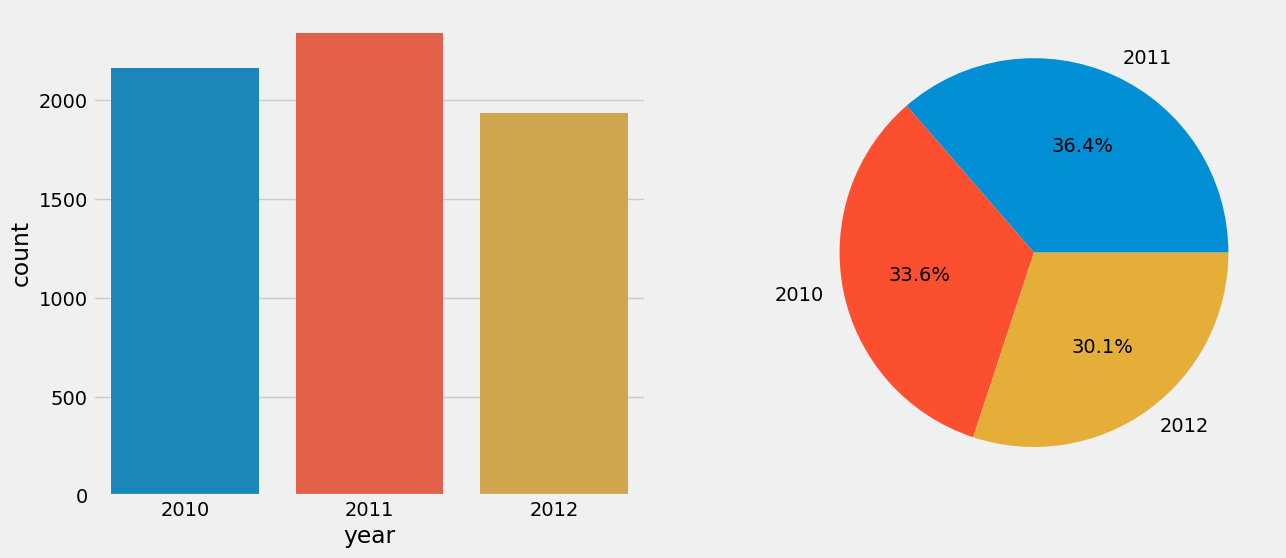

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
sns.countplot(data = data, x = 'year', ax = ax[0])
ax[1].pie(data['year'].value_counts().values,
          labels = data['year'].value_counts().index,
          autopct = '%1.1f%%')
plt.show()

**Conclusion:**

- 2011 is the most frequent in the dataset because most of the weekly sales were recorded during this year.

### 2.3. season

In [23]:
data['season'].value_counts()

Summer    1800
Spring    1755
Winter    1485
Autumn    1395
Name: season, dtype: int64

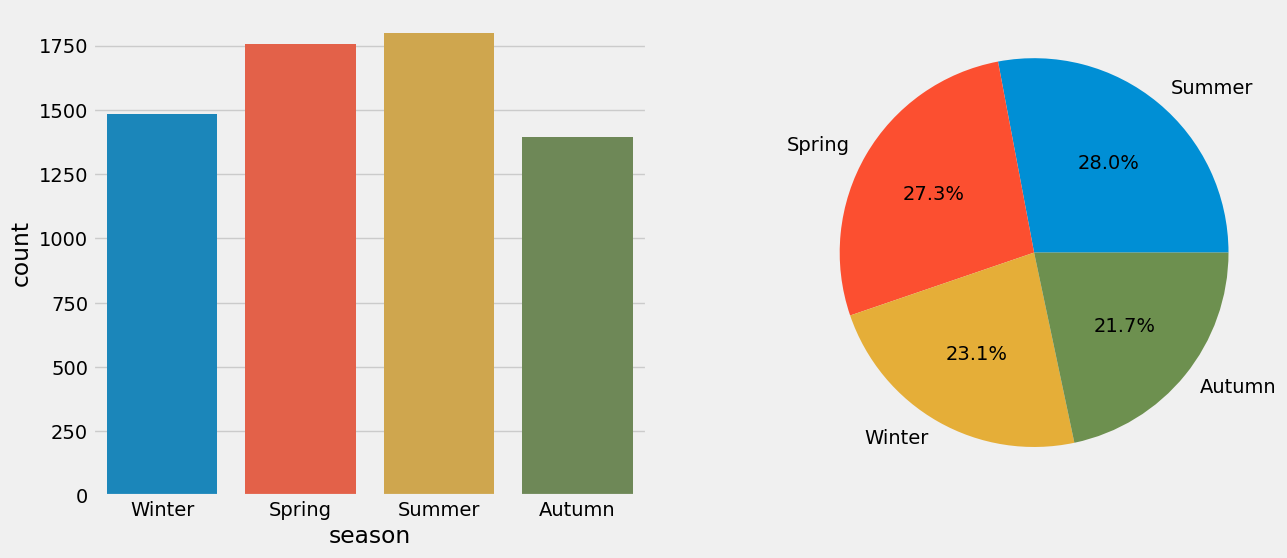

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
sns.countplot(data = data, x = 'season', ax = ax[0])
ax[1].pie(data['season'].value_counts().values,
          labels = data['season'].value_counts().index,
          autopct = '%1.1f%%')
plt.show()

**Conclusion:**

- Summer is the most frequent in the dataset because most of the weekly sales were recorded during this season.

### 2.4. month_name

In [25]:
data['month_name'].value_counts()

April        630
July         630
March        585
June         585
August       585
September    585
October      585
February     540
May          540
December     450
November     360
January      360
Name: month_name, dtype: int64

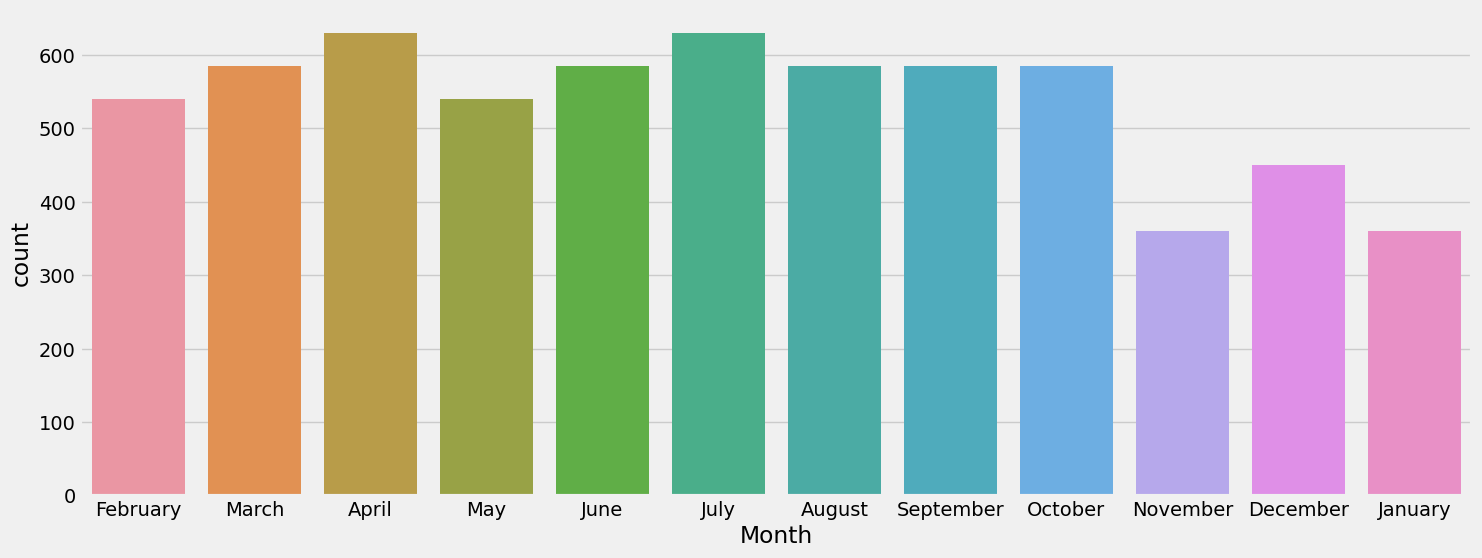

In [26]:
plt.figure(figsize=(16, 6))
sns.countplot(data = data, x = 'month_name')
plt.xlabel('Month')
plt.show()

**Conclusion:**

- April and July are the most frequent in the dataset because most of the weekly sales were recorded in these months.

### 2.5. day_of_week

In [27]:
data['day_of_week'].value_counts()

Friday    6435
Name: day_of_week, dtype: int64

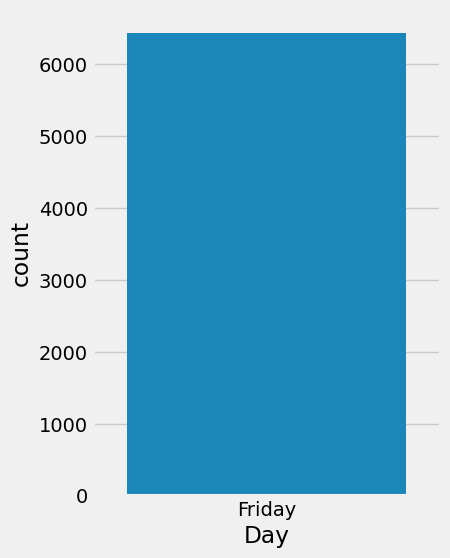

In [28]:
plt.figure(figsize=(4, 6))
sns.countplot(data = data, x = 'day_of_week')
plt.xlabel('Day')
plt.show()

**Conclusion:**

- Friday is frequented in each row.

### 2.6. store

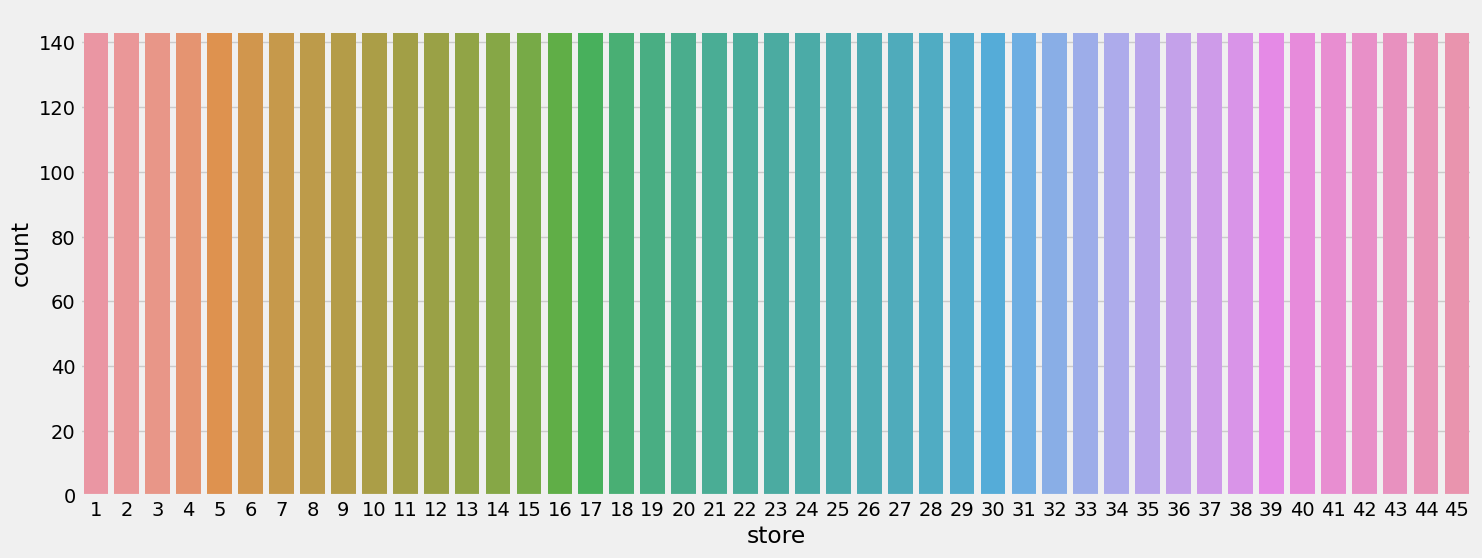

In [29]:
plt.figure(figsize=(16, 6))
sns.countplot(data = data, x = 'store')
plt.show()

**Conclusion:**

- All stores are frequent with the same count in the dataset.

---

## Bi-variate Analysis

### 1. weekly_sales & is_holiday

#### Q1: What are the average sales on holidays and regular days?  

In [30]:
data.groupby('is_holiday')['weekly_sales'].mean()

is_holiday
0   1,041,256
1   1,122,888
Name: weekly_sales, dtype: float64

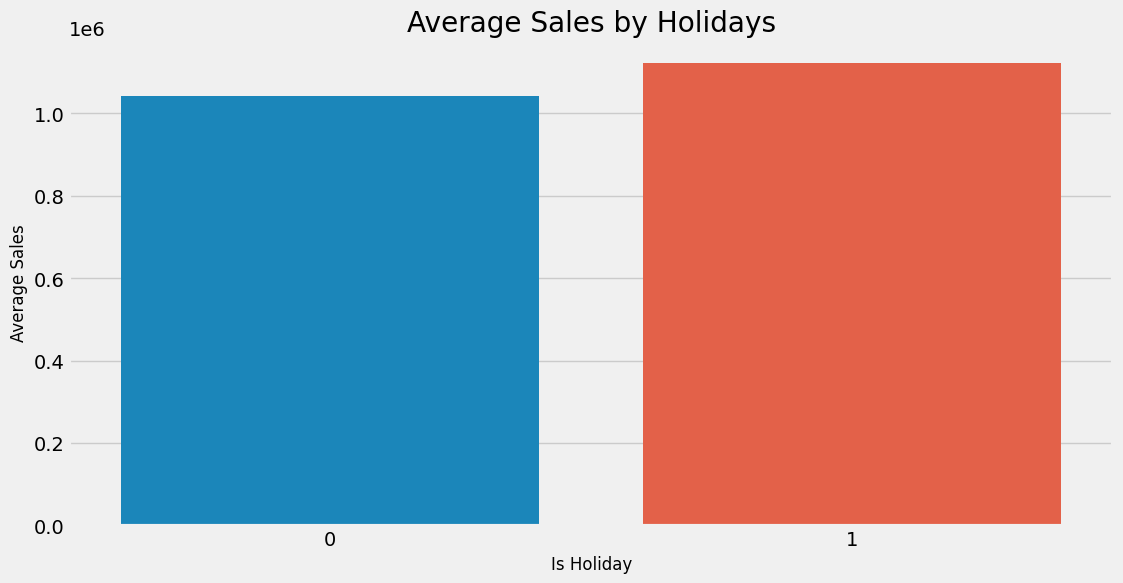

In [31]:
plt.figure(figsize = (12, 6))
sns.barplot(data = data,
            x = 'is_holiday',
            y = 'weekly_sales',
            estimator = np.mean,
            ci = False)

# Add labels and title
plt.title('Average Sales by Holidays')
plt.xlabel('Is Holiday', size = 12)
plt.ylabel('Average Sales', size = 12)
plt.show()

**Conclusion:**

- The rate of sales on holidays is higher than on other days.

#### Q2: What are the total sales on holidays and regular days?

In [32]:
data.groupby('is_holiday')['weekly_sales'].sum()

is_holiday
0   6,231,919,436
1     505,299,552
Name: weekly_sales, dtype: float64

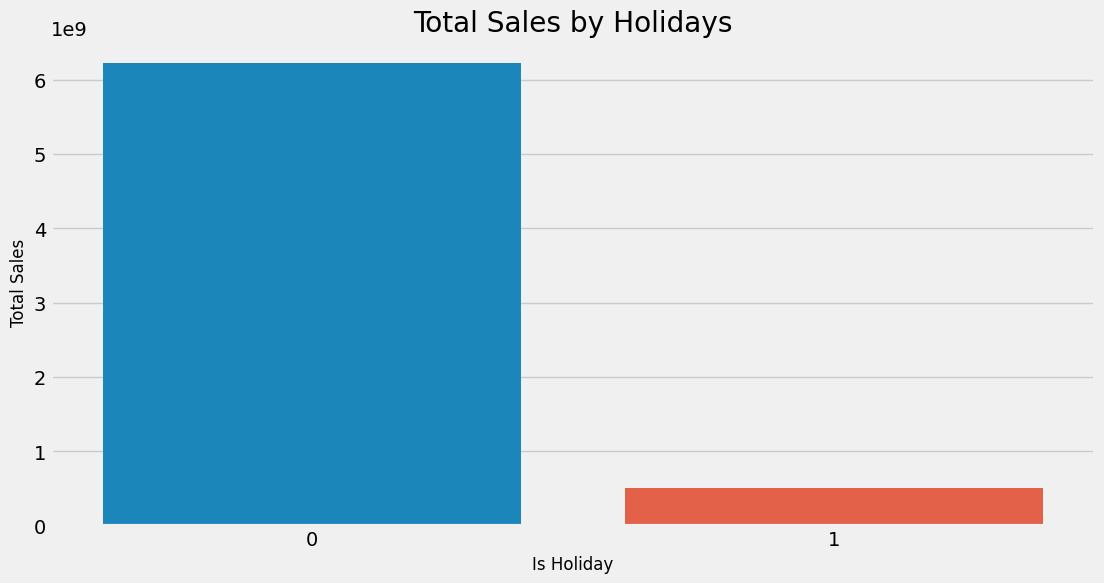

In [33]:
plt.figure(figsize = (12, 6))
sns.barplot(data = data,
            x = 'is_holiday',
            y = 'weekly_sales',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales by Holidays')
plt.xlabel('Is Holiday', size = 12)
plt.ylabel('Total Sales', size = 12)
plt.show()

**Conclusion:**

- Total sales on holidays are lower than on other days, which is normal because the number of holidays is very small compared with the number of other days.

### 2. weekly_sales & store

#### Q3: What are the total sales in each store?

In [34]:
gb_store = data.groupby('store')['weekly_sales'].sum().sort_values(ascending = False)
gb_store

store
20   301,397,792
4    299,543,953
14   288,999,911
13   286,517,704
2    275,382,441
10   271,617,714
27   253,855,917
6    223,756,131
1    222,402,809
39   207,445,542
19   206,634,862
31   199,613,906
23   198,750,618
24   194,016,021
11   193,962,787
28   189,263,681
41   181,341,935
32   166,819,246
18   155,114,734
22   147,075,649
12   144,287,230
26   143,416,394
34   138,249,763
40   137,870,310
35   131,520,672
8    129,951,181
17   127,782,139
45   112,395,341
21   108,117,879
25   101,061,179
43    90,565,435
15    89,133,684
7     81,598,275
42    79,565,752
9     77,789,219
29    77,141,554
16    74,252,425
37    74,202,740
30    62,716,885
3     57,586,735
38    55,159,626
36    53,412,215
5     45,475,689
44    43,293,088
33    37,160,222
Name: weekly_sales, dtype: float64

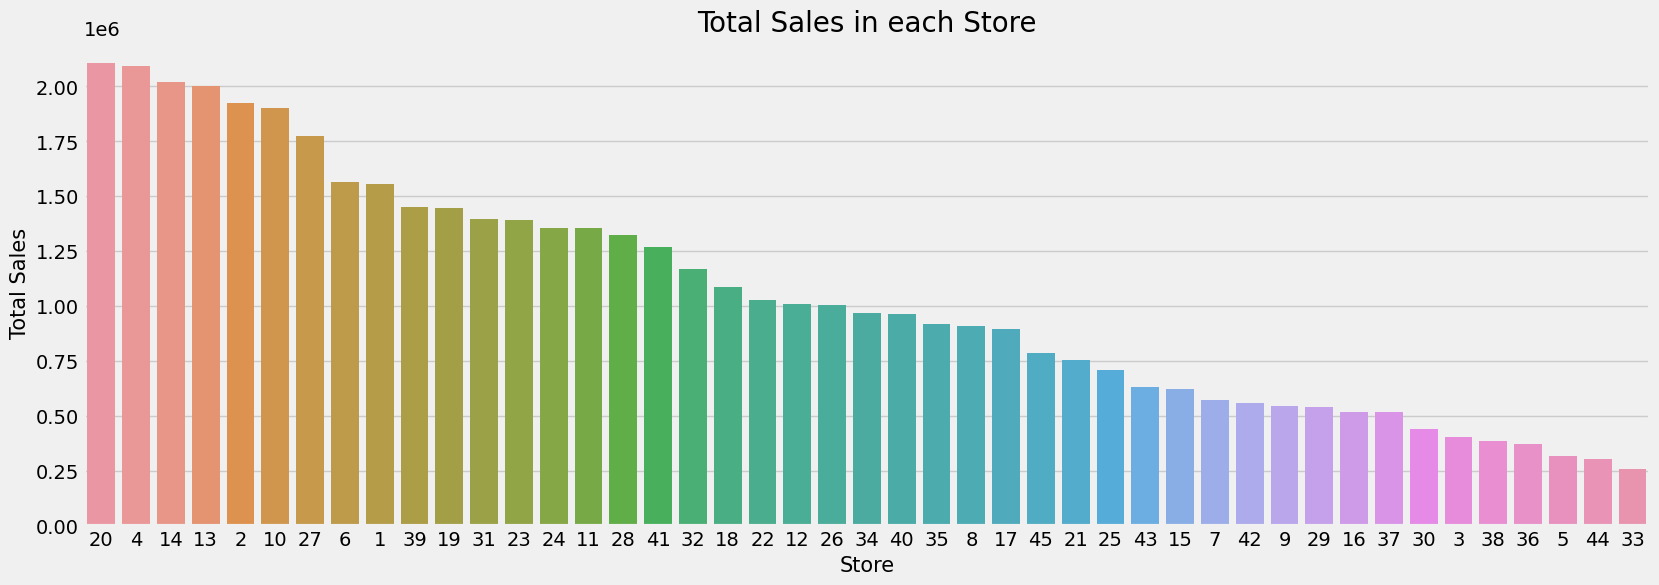

In [35]:
plt.figure(figsize = (18, 6))
sns.barplot(data = data,
            x = 'store',
            y = 'weekly_sales',
            order = gb_store.index,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Store', size = 20)
plt.xlabel('Store', size = 15)
plt.ylabel('Total Sales', size = 15)
plt.show()

**Conclusion:**

- There is a high variance in weekly sales from one store to another.
- Store No. 20 has the highest sales from any store with 301,397,792 followed by Store No. 4 with 299,543,953 and Store No. 33 comes last with 37,160,222$.

### 3. weekly_sales & temperature

#### Q4: What happens to sales in the different temperatures?

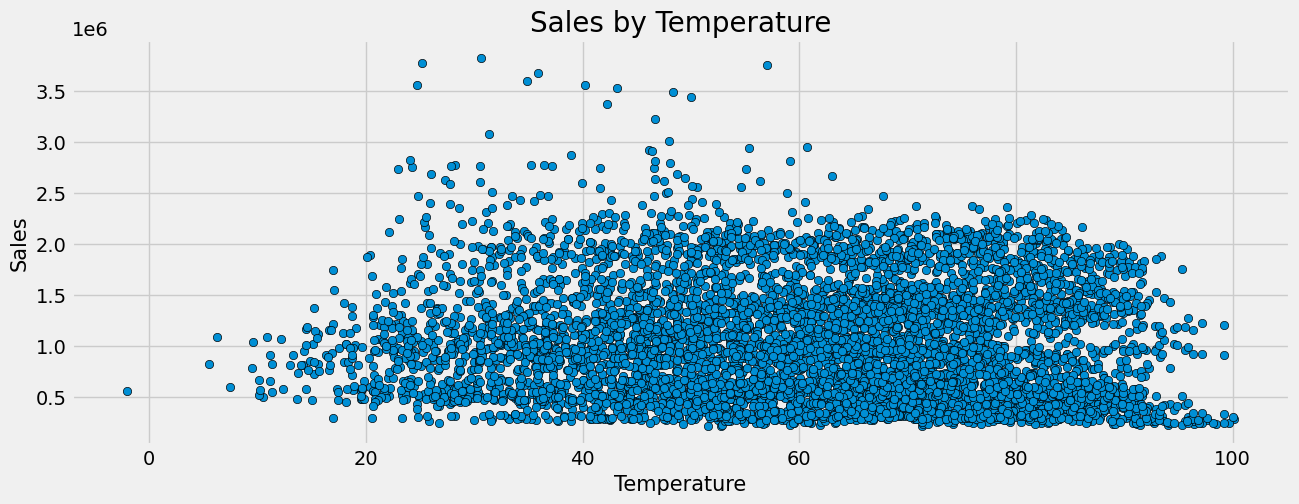

In [36]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,
                x = 'temperature',
                y = 'weekly_sales',
                edgecolor = "black")

# Add labels and title
plt.title('Sales by Temperature', size = 20)
plt.xlabel('Temperature', size = 15)
plt.ylabel('Sales', size = 15)
plt.show()

**Conclusion:**

- Sales are not affected by changes in temperature.

### 4. weekly_sales & fule_price

#### Q5: What happens to sales with an increase in fuel price?

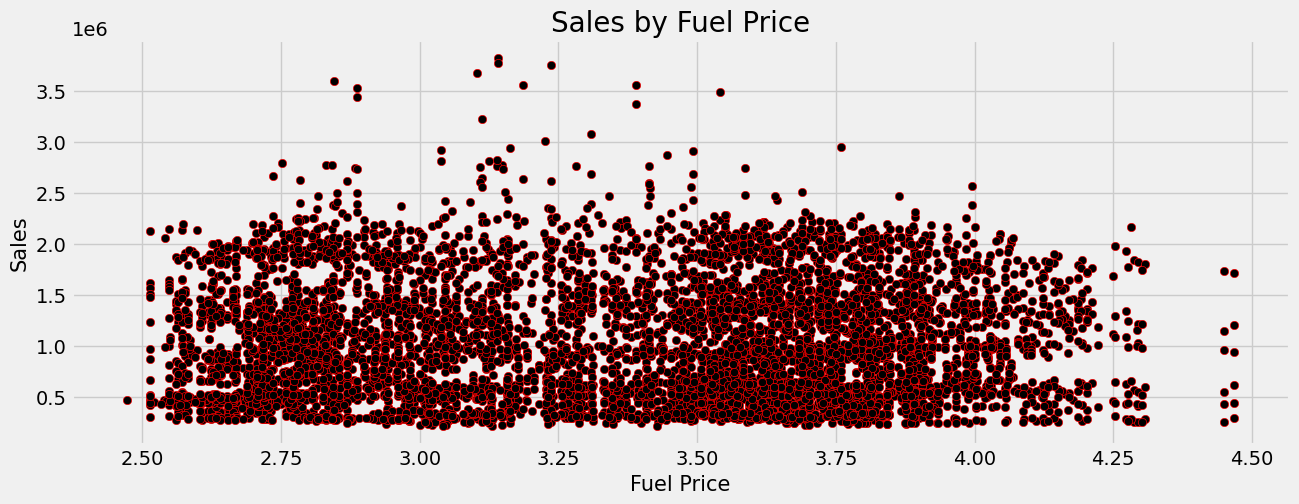

In [37]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,
                x = 'fuel_price',
                y = 'weekly_sales',
                color = 'black',
                edgecolor = "red")

# Add labels and title
plt.title('Sales by Fuel Price', size = 20)
plt.xlabel('Fuel Price', size = 15)
plt.ylabel('Sales', size = 15)
plt.show()

**Conclusion:**

- Sales are not affected by an increase in fuel price.

### 5. weekly_sales & cpi

#### Q6: What happens to sales based on Consumer Price Index (CPI) or the consumer's economic condition?

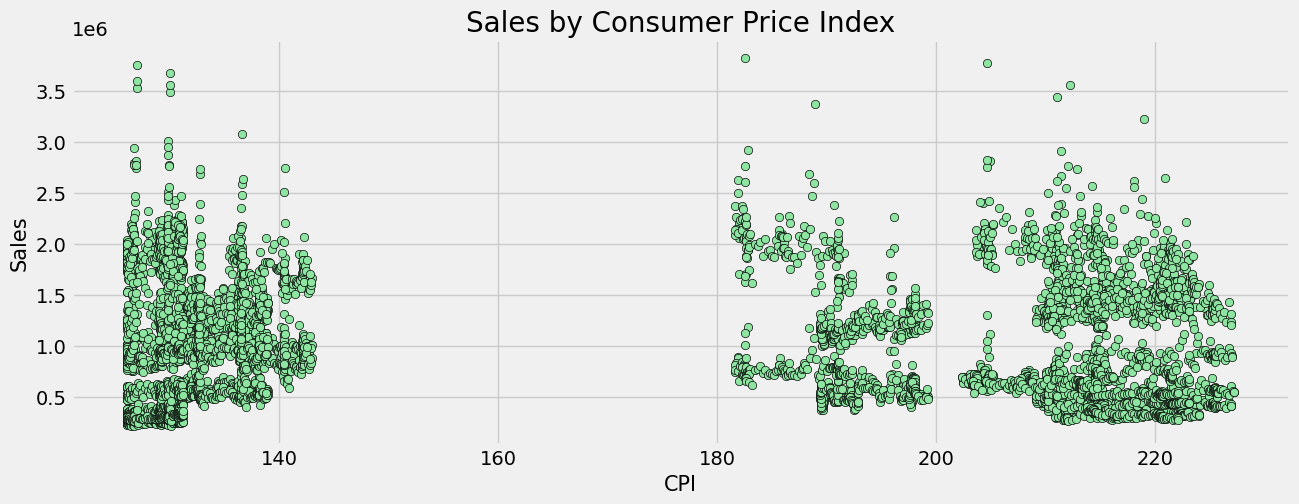

In [38]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,
                x = 'cpi',
                y = 'weekly_sales',
                color = '#8de5a1',
                edgecolor = "black")

# Add labels and title
plt.title('Sales by Consumer Price Index', size = 20)
plt.xlabel('CPI', size = 15)
plt.ylabel('Sales', size = 15)
plt.show()

**Conclusion:**

- Consumer Price Index (CPI) does not affect sales. And based on the distribution of average consumer prices in the above figure, customers can be divided into two categories:
  - customers who pay from 120 to 150 (Middle-class customers).
  - customers who pay from 180 to 230 (High-class customers).

### 6. weekly_sales & unemployment

#### Q7: What happens to sales based on the unemployment rate?

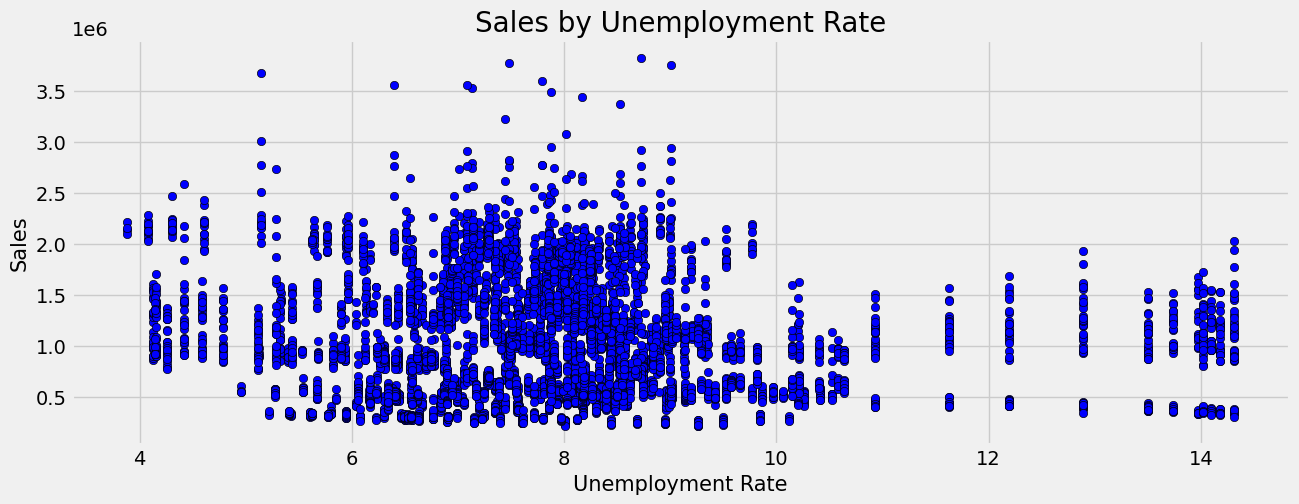

In [39]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,
                x = 'unemployment',
                y = 'weekly_sales',
                color = 'blue',
                edgecolor = 'black')

# Add labels and title
plt.title('Sales by Unemployment Rate', size = 20)
plt.xlabel('Unemployment Rate', size = 15)
plt.ylabel('Sales', size = 15)
plt.show()

**Conclusion:**

- Sales are affected by the unemployment rate, so the higher the unemployment rate, the lower the sales.

---

## Time Series Analysis

#### Q8: What are the total sales in each year?

In [40]:
data.groupby('year')['weekly_sales'].sum().sort_values(ascending = False)

year
2011   2,448,200,007
2010   2,288,886,120
2012   2,000,132,859
Name: weekly_sales, dtype: float64

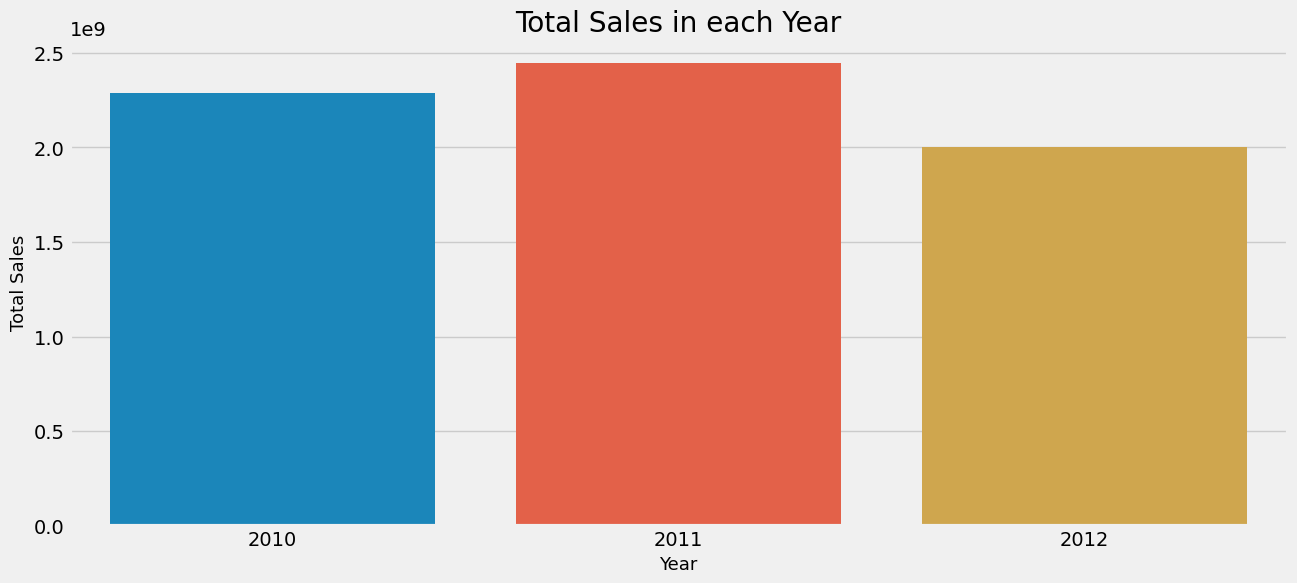

In [41]:
plt.figure(figsize = (14, 6))
sns.barplot(data = data,
            x = 'year',
            y = 'weekly_sales',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Year')
plt.xlabel('Year', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

**Conclusion:**

- Total sales in 2011 were the highest, with 2,448,200,007$.

#### Q9: What are the total sales in each season?

In [42]:
data.groupby('season')['weekly_sales'].sum().sort_values(ascending = False)

season
Summer   1,841,852,365
Spring   1,826,615,244
Autumn   1,574,639,148
Winter   1,494,112,230
Name: weekly_sales, dtype: float64

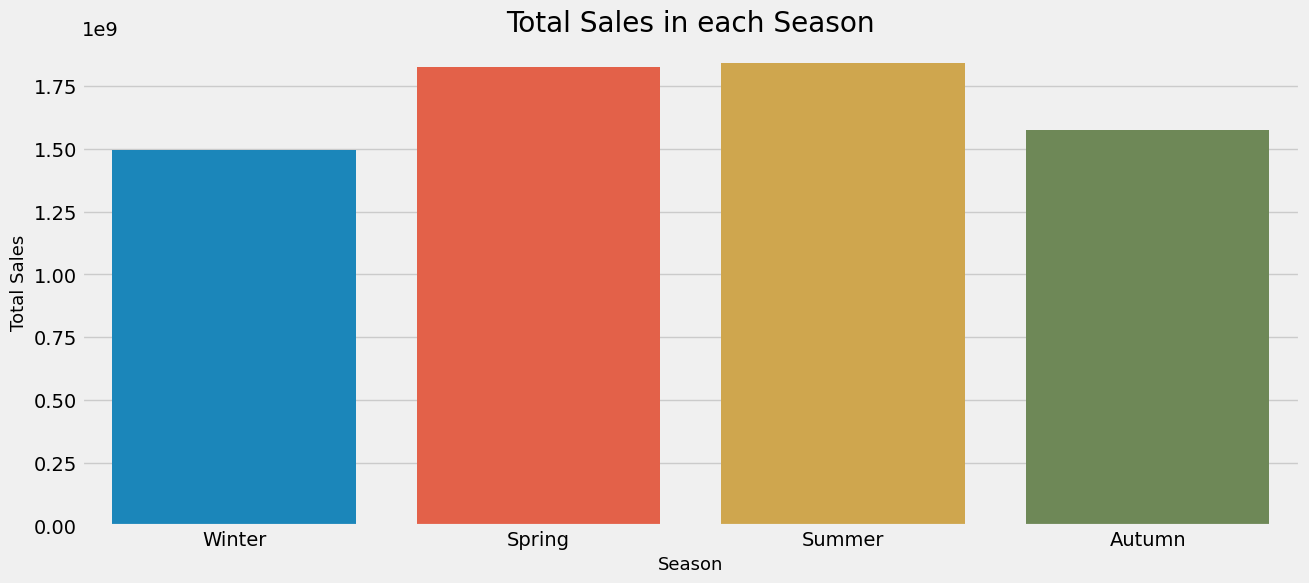

In [43]:
plt.figure(figsize = (14, 6))
sns.barplot(data = data,
            x = 'season',
            y = 'weekly_sales',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Season')
plt.xlabel('Season', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

**Conclusion:**

- Total sales for all years in Summer are the highest from all seasons, with 1,1,841,852,365$.

#### Q10: What are the total sales in each month?

In [44]:
data.groupby('month_name')['weekly_sales'].sum().sort_values(ascending = False)

month_name
July        650,000,977
April       646,859,785
June        622,629,887
August      613,090,209
March       592,785,901
October     584,784,788
September   578,761,179
December    576,838,635
February    568,727,890
May         557,125,572
November    413,015,725
January     332,598,438
Name: weekly_sales, dtype: float64

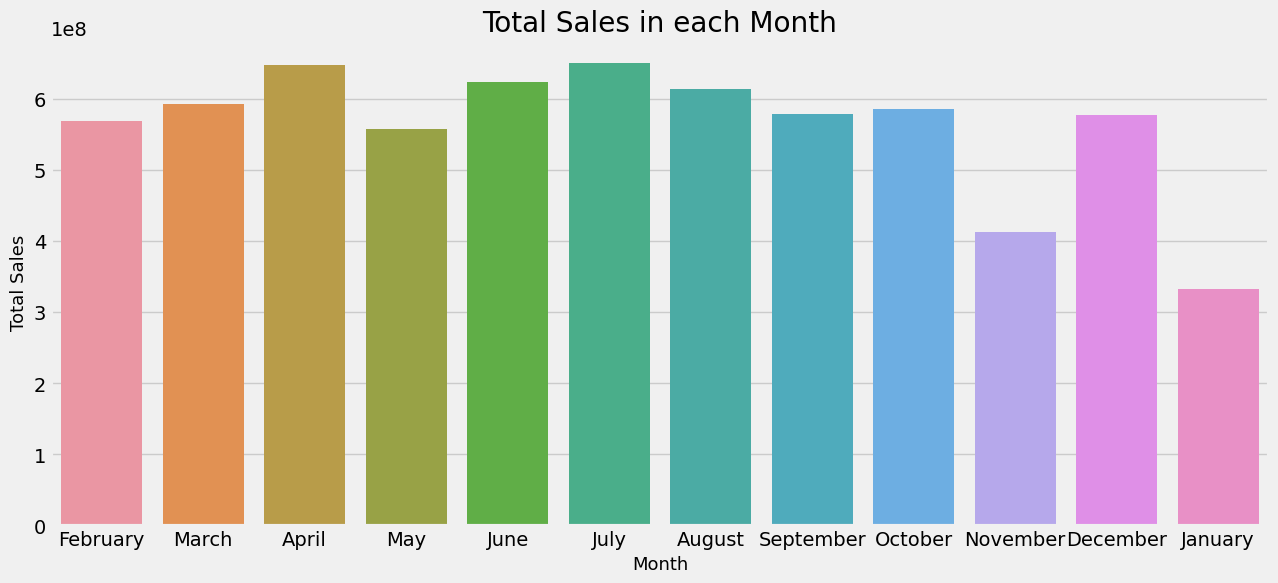

In [45]:
plt.figure(figsize = (14, 6))
sns.barplot(data = data,
            x = 'month_name',
            y = 'weekly_sales',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Month')
plt.xlabel('Month', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

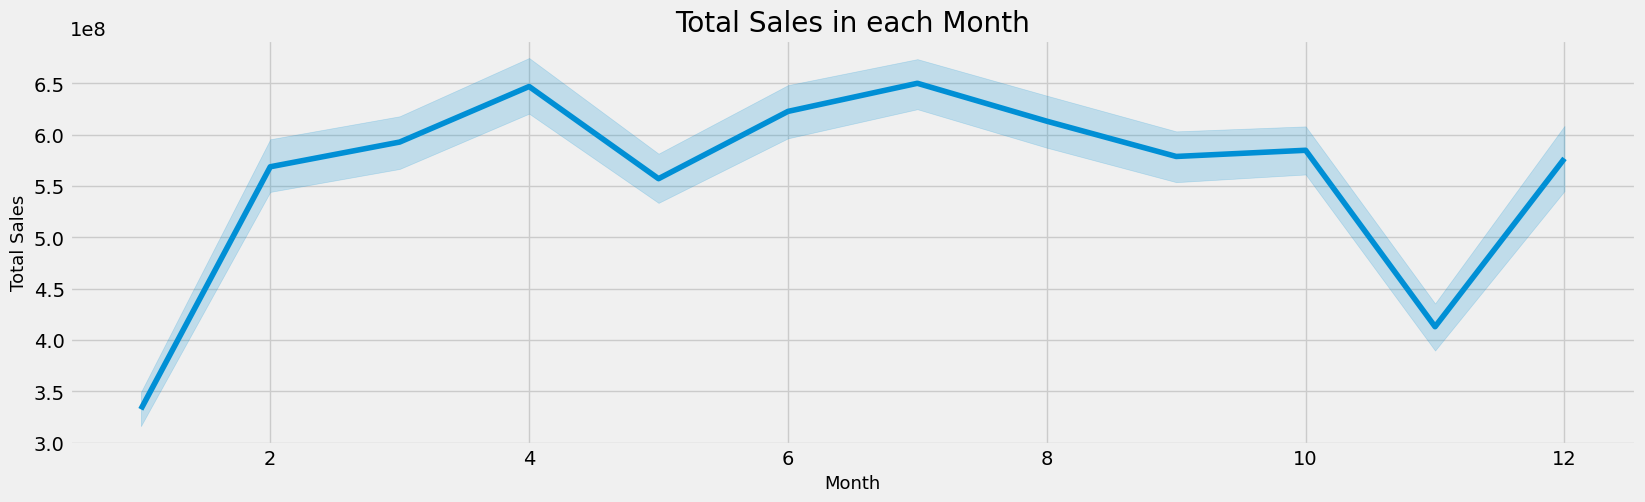

In [48]:
plt.figure(figsize = (18, 5))
sns.lineplot(data = data,
            x = 'month',
            y = 'weekly_sales',
            estimator = np.sum)

# Add labels and title
plt.title('Total Sales in each Month')
plt.xlabel('Month', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

**Conclusion:**

- Total sales for all years in July are the highest from any month, with 650,000,977$.

#### Q11: What are the total sales in each week?

In [49]:
gp_week = data.groupby('week')['weekly_sales'].sum().sort_values(ascending = False)
gp_week

week
51   157,929,657
22   147,242,187
7    147,190,215
27   147,011,815
14   146,755,073
6    145,682,278
23   145,147,453
31   143,706,366
24   143,481,719
26   143,093,116
18   142,489,400
5    141,989,460
33   141,332,753
21   140,943,423
34   140,774,012
36   140,727,685
9    140,713,109
25   140,161,416
32   140,117,439
40   139,881,302
35   139,730,520
13   139,155,684
16   138,483,674
10   138,033,170
28   137,859,562
19   137,702,104
15   136,786,257
11   136,762,806
29   136,222,804
20   135,990,645
43   135,002,768
42   134,008,034
8    133,865,938
41   133,652,808
47   132,414,608
30   132,410,793
12   132,003,955
37   131,100,725
17   130,951,958
38   128,431,158
39   128,170,606
50   121,906,496
49   111,227,918
48    99,299,584
45    94,599,026
44    94,437,526
46    91,564,565
1     87,731,210
52    86,474,980
3     82,735,645
2     82,696,757
4     79,434,828
Name: weekly_sales, dtype: float64

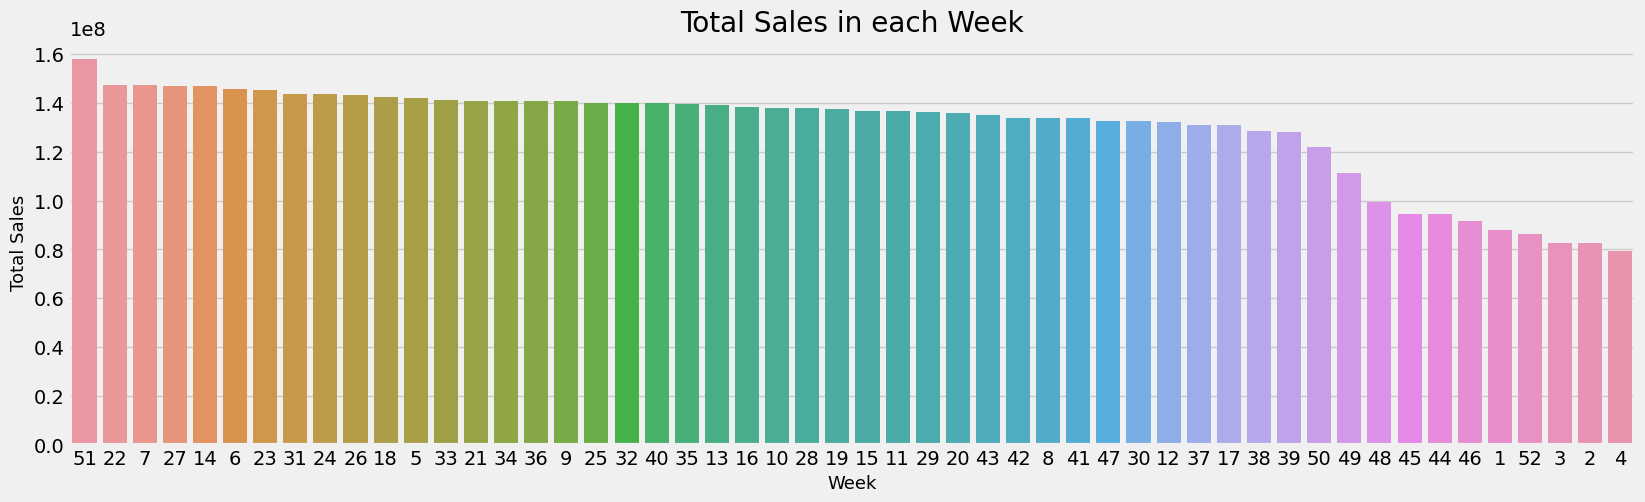

In [50]:
plt.figure(figsize = (18, 5))
sns.barplot(data = data,
            x = 'week',
            y = 'weekly_sales',
            estimator = np.sum,
            order = gp_week.index,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Week')
plt.xlabel('Week', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

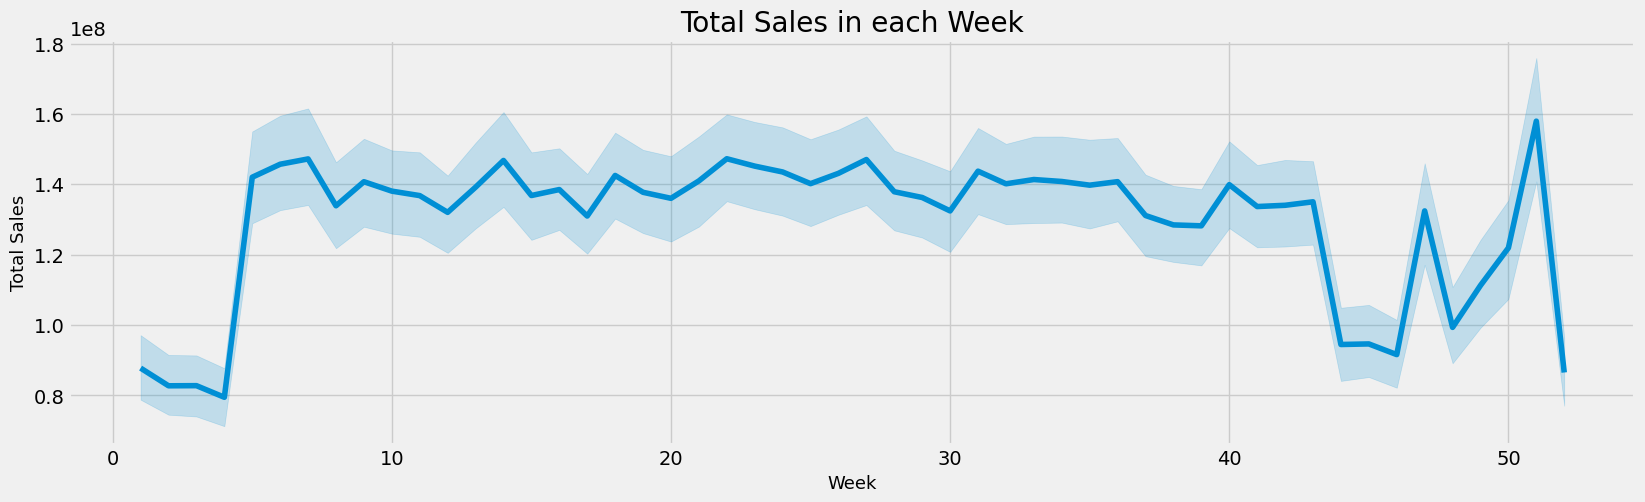

In [53]:
plt.figure(figsize = (18, 5))
sns.lineplot(data = data,
            x = 'week',
            y = 'weekly_sales',
            estimator = np.sum)

# Add labels and title
plt.title('Total Sales in each Week')
plt.xlabel('Week', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

**Conclusion:**

- Total sales for all years in week 51 are the highest from any week, with 157,929,657$.

#### Q12: What are the total sales in each year regarding the month?

In [54]:
pd.pivot_table(data = data,
               index = 'year',
               columns = 'month_name',
               values = 'weekly_sales',
               aggfunc = 'sum')

month_name       April      August    December    February     January  \
year                                                                     
2010       231,412,368 187,640,111 288,760,533 190,332,983         NaN   
2011       226,526,511 188,599,332 288,078,102 186,331,328 163,703,967   
2012       188,920,906 236,850,766         NaN 192,063,580 168,894,472   

month_name        July        June       March         May    November  \
year                                                                     
2010       232,580,126 192,246,172 181,919,802 186,710,934 202,853,370   
2011       229,911,399 189,773,385 179,356,448 181,648,158 210,162,355   
2012       187,509,452 240,610,329 231,509,650 188,766,479         NaN   

month_name     October   September  
year                                
2010       217,161,824 177,267,896  
2011       183,261,283 220,847,738  
2012       184,361,680 180,645,544

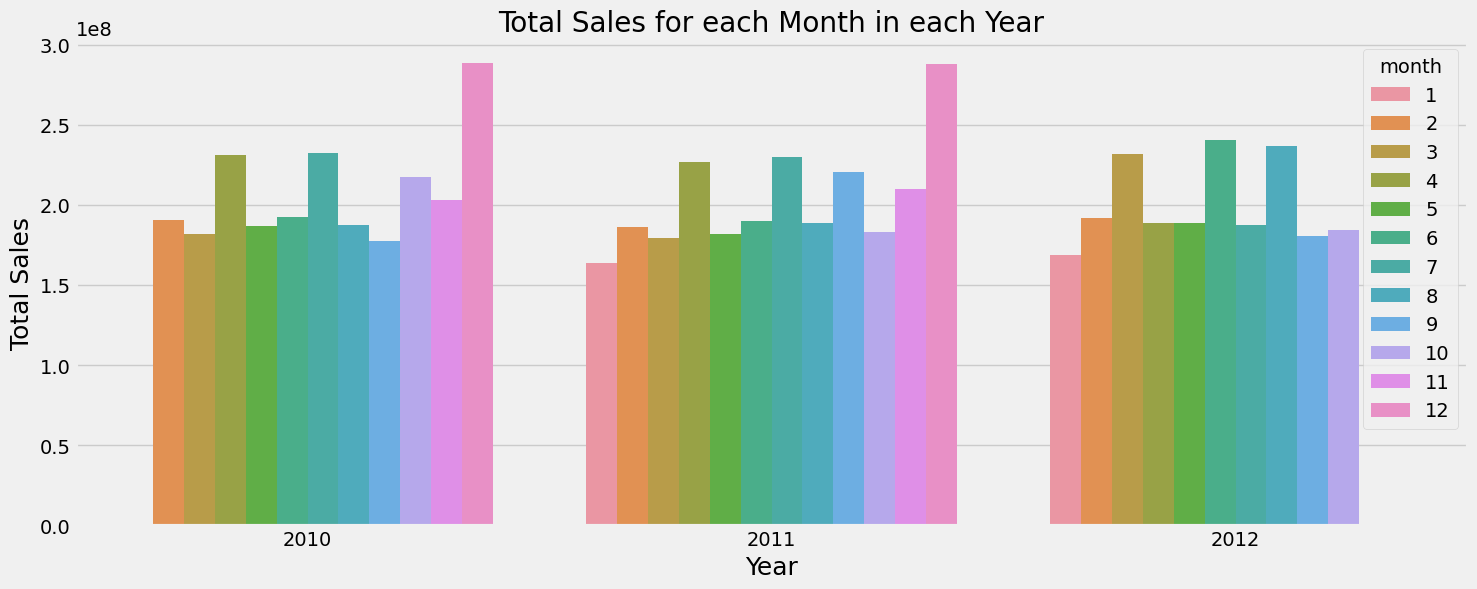

In [55]:
plt.figure(figsize = (16, 6))
sns.barplot(data = data,
            x = 'year',
            y = 'weekly_sales',
            hue = 'month',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales for each Month in each Year')
plt.xlabel('Year', size = 18)
plt.ylabel('Total Sales', size = 18)

plt.show()

**Conclusion:**

Total sales in December 2010, 2011 are the highest in the three years, where:

- In 2010, total sales in December were the highest with 288,760,533.
- In 2011, total sales in December were the highest with 288,760,533.
- In 2012, total sales in June were the highest with 240,610,329$.

#### Q13: What are the total sales in each year regarding the season?

In [56]:
pd.pivot_table(data = data,
               index = 'year',
               columns = 'season',
               values = 'weekly_sales',
               aggfunc = 'sum')

season      Autumn      Spring      Summer      Winter
year                                                  
2010   708,775,727 610,369,475 597,488,133 372,252,786
2011   681,501,740 597,948,054 639,358,470 529,391,743
2012   184,361,680 618,297,715 605,005,763 592,467,702

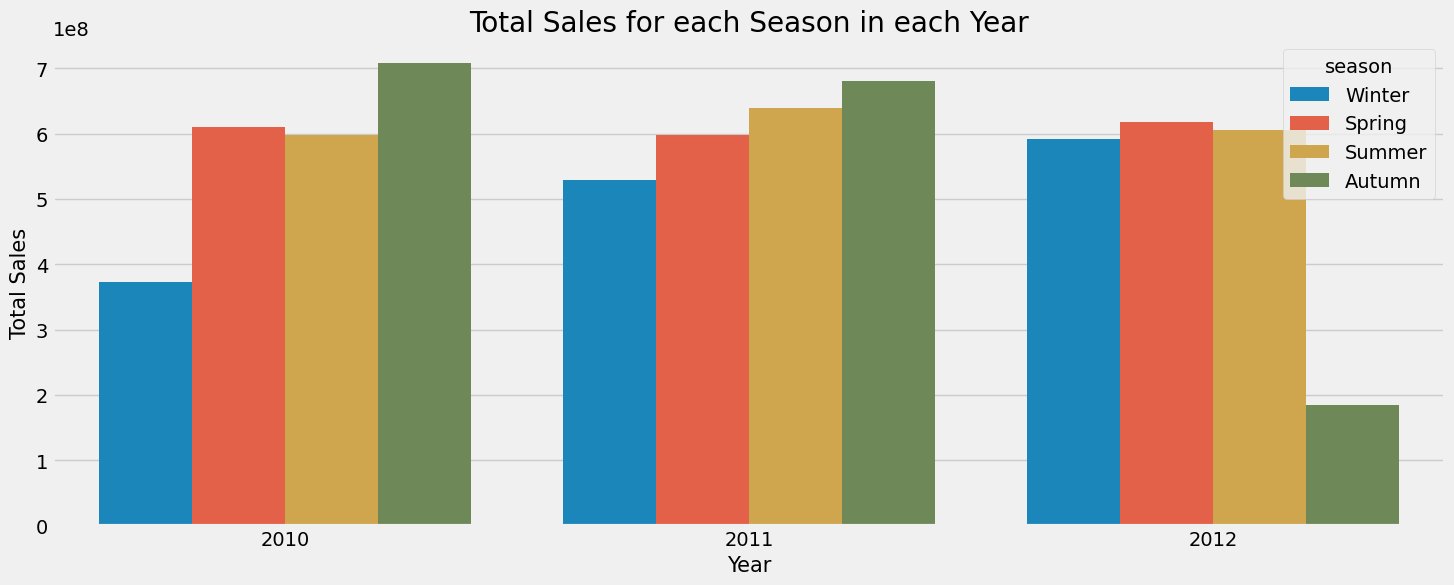

In [57]:
plt.figure(figsize = (16, 6))
sns.barplot(data = data,
            x = 'year',
            y = 'weekly_sales',
            hue = 'season',
            estimator = np.sum,
           ci = False)

# Add labels and title
plt.title('Total Sales for each Season in each Year')
plt.xlabel('Year', size = 15)
plt.ylabel('Total Sales', size = 15)
plt.show()

**Conclusion:**

Total sales in Autumn 2010 were the highest in the three years, where:

   - In 2010, total sales in Autumn were the highest with 708,775,727.
   - In 2011, total sales in Autumn were the highest with 681,501,740.
   - In 2012, total sales in Spring were the highest with 618,297,715$.

#### Q14: What are the total sales in each year regarding the day of the week?

In [58]:
pd.pivot_table(data = data,
               index = 'year',
               columns = 'day_of_week',
               values = 'weekly_sales',
               aggfunc = 'sum')

day_of_week        Friday
year                     
2010        2,288,886,120
2011        2,448,200,007
2012        2,000,132,859

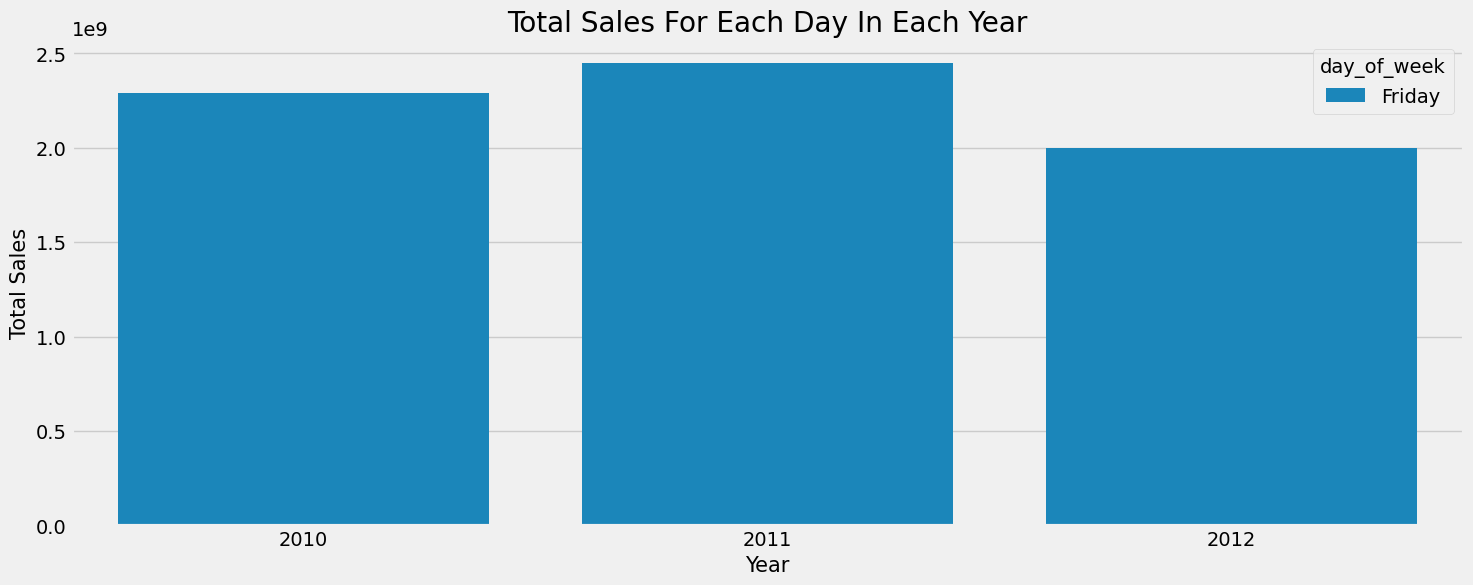

In [59]:
plt.figure(figsize = (16, 6))
sns.barplot(data = data,
            x = 'year',
            y = 'weekly_sales',
            hue = 'day_of_week',
            estimator = np.sum,
           ci = False)

# Add labels and title
plt.title('Total Sales For Each Day In Each Year')
plt.xlabel('Year', size = 15)
plt.ylabel('Total Sales', size = 15)
plt.show()

**Conclusion:**

- Total weekly sales in Fridays 2011 were the highest in the three years, where:
  - In 2010, total sales on Fridays were the highest with 2,288,886,120.
  - In 2011, total sales on Fridays were the highest with 2,448,200,007.
  - In 2012, total sales on Fridays were the highest with 2,000,132,859.

#### Q15: What happened to the total sales over time?

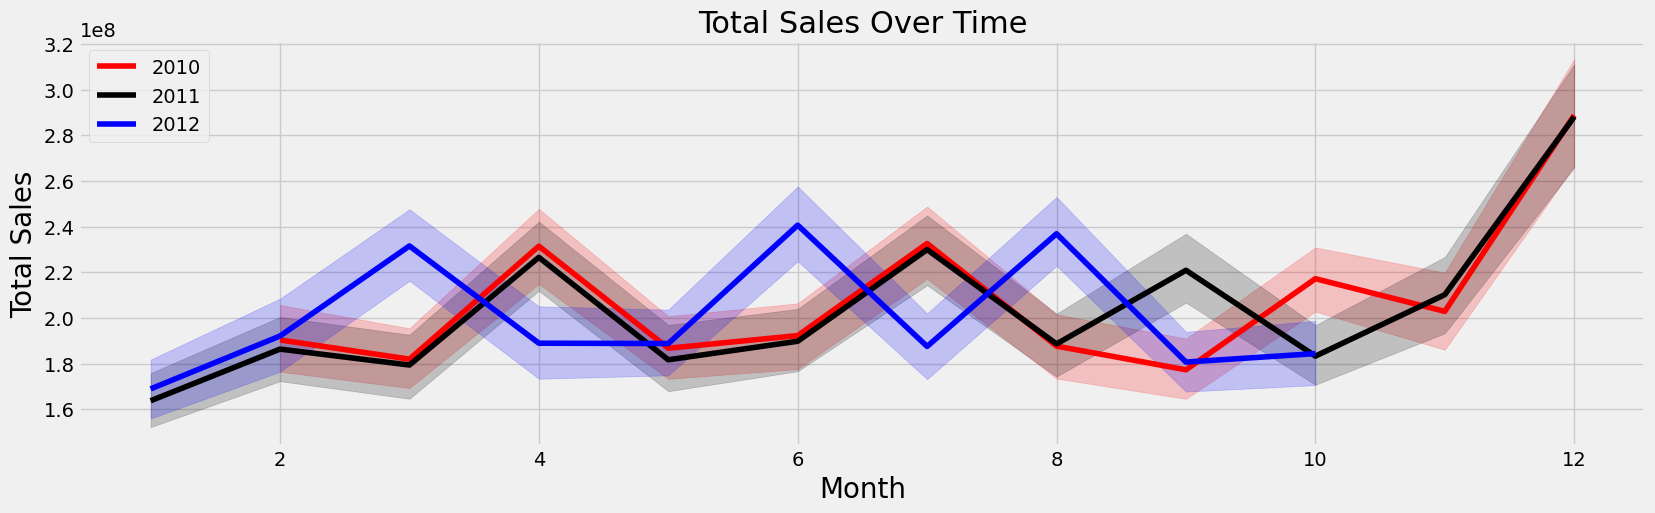

In [60]:
years = ['2010', '2011', '2012']
colors = ['red', 'black', 'blue']

plt.figure(figsize = (18, 5))
for i, year in enumerate(years):
    sns.lineplot(data = data[data['year'] == int(year)],
                 x = 'month',
                 y = 'weekly_sales',
                 estimator = np.sum,
                 color = colors[i],
                 label = year)

# Add labels and title
plt.title(f'Total Sales Over Time', size = 22)
plt.xlabel('Month', size = 20)
plt.ylabel('Total Sales', size = 20)

# Add a legend
plt.legend()

# Show the plot
plt.show()

**Conclusion:**

- Sales are similar in most months, but they increased at the end of 2010 and 2011 and decreased at the end of 2012.

#### Q17: What happened to the average sales over time?

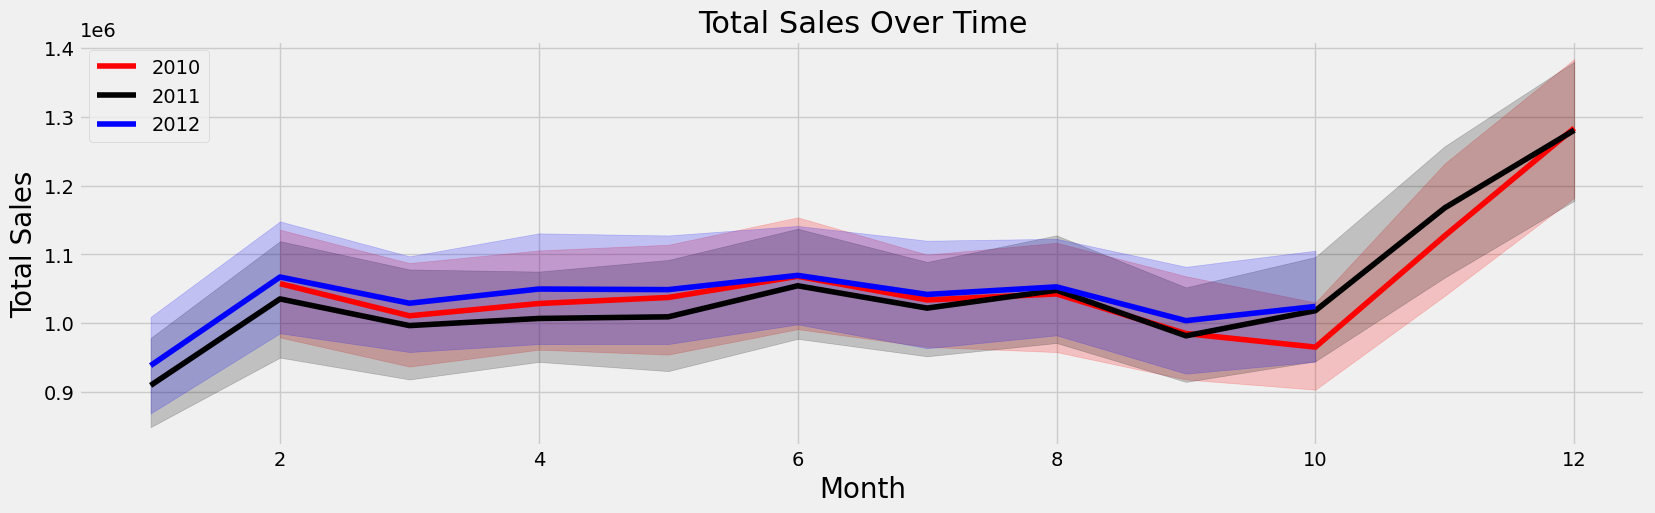

In [61]:
plt.figure(figsize = (18, 5))
for i, year in enumerate(years):
    sns.lineplot(data = data[data['year'] == int(year)],
                 x = 'month',
                 y = 'weekly_sales',
                 estimator = np.mean,
                 color = colors[i],
                 label = year)

# Add labels and title
plt.title(f'Total Sales Over Time', size = 22)
plt.xlabel('Month', size = 20)
plt.ylabel('Total Sales', size = 20)

# Add a legend
plt.legend()

# Show the plot
plt.show()

**Conclusion:**

- Sales rates are similar in most months, but they increased at the end of 2010 and 2011 and decreased at the end of 2012.

#### Q18: What happens to the unemployment rate over time?

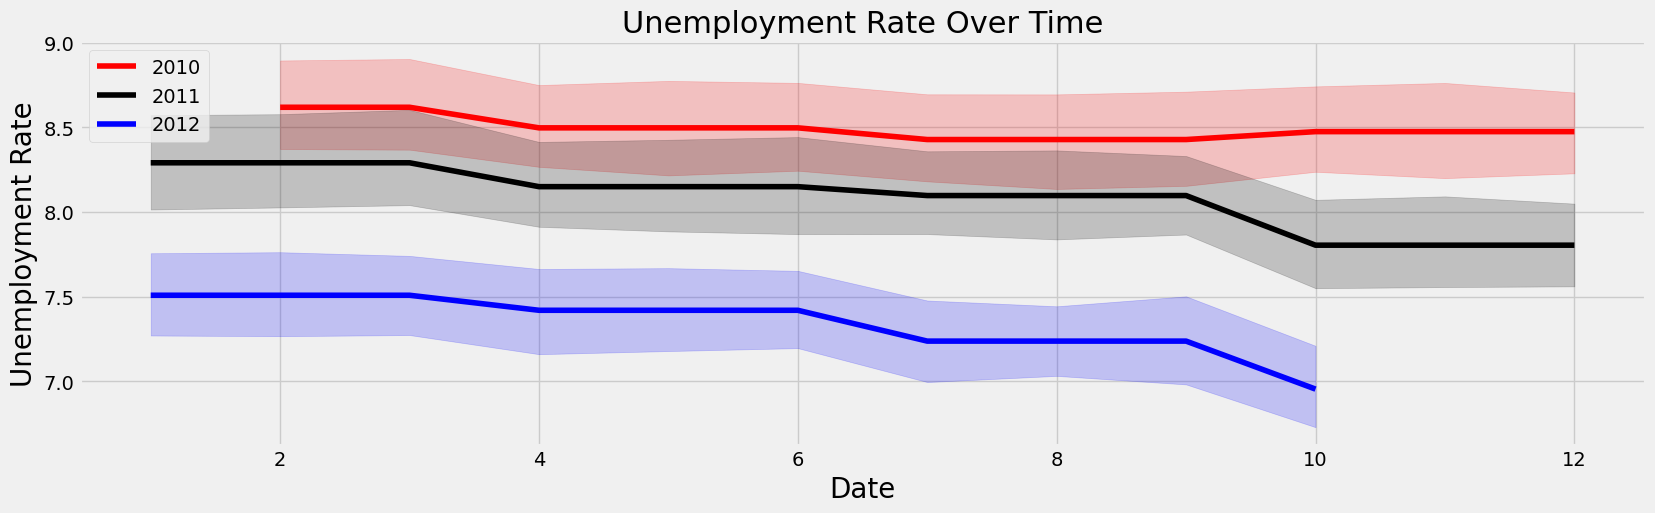

In [62]:
plt.figure(figsize = (18, 5))
for i, year in enumerate(years):
    sns.lineplot(data = data[data['year'] == int(year)],
                 x = 'month',
                 y = 'unemployment',
                 estimator = np.mean,
                 color = colors[i],
                 label = year)

# Add labels and title
plt.title(f'Unemployment Rate Over Time', size = 22)
plt.xlabel('Date', size = 20)
plt.ylabel('Unemployment Rate', size = 20)

# Add a legend
plt.legend()

# Show the plot
plt.show()

**Conclusion:**

- The unemployment rate decreases over time.

#### Q19: What happens to the fuel price rate over time?

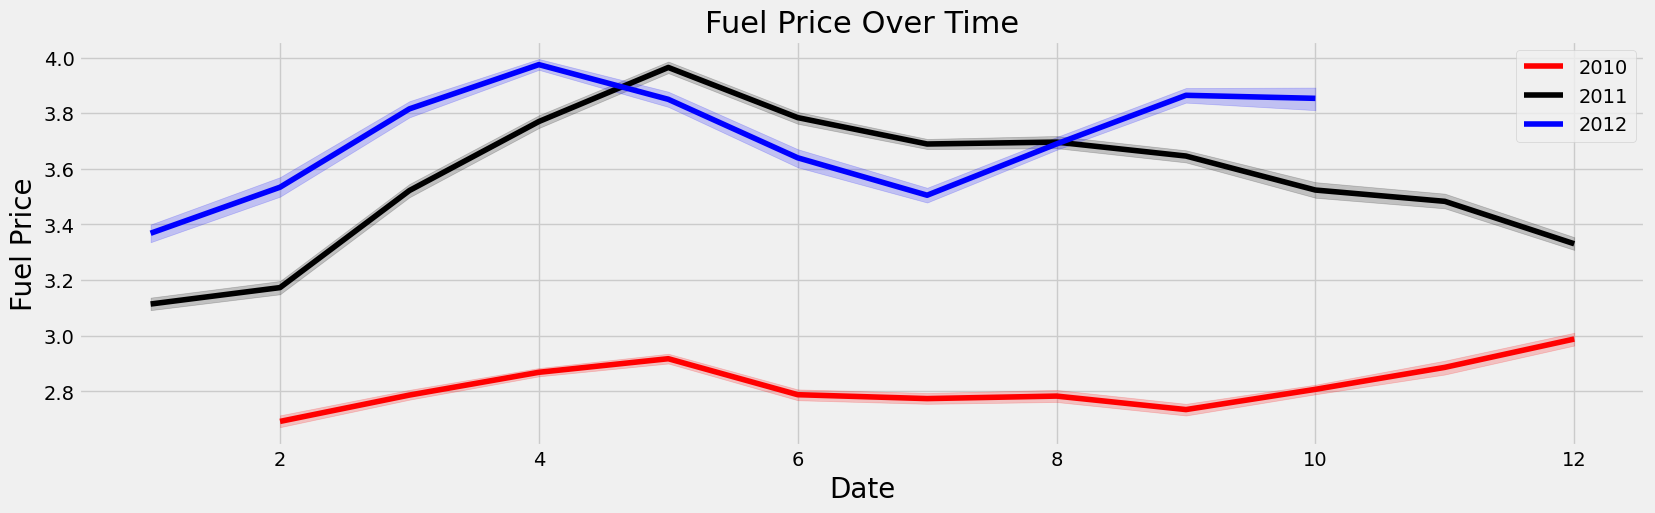

In [63]:
plt.figure(figsize = (18, 5))
for i, year in enumerate(years):
    sns.lineplot(data = data[data['year'] == int(year)],
                 x = 'month',
                 y = 'fuel_price',
                 estimator = np.mean,
                 color = colors[i],
                 label = year)

# Add labels and title
plt.title(f'Fuel Price Over Time', size = 22)
plt.xlabel('Date', size = 20)
plt.ylabel('Fuel Price', size = 20)

# Add a legend
plt.legend()

# Show the plot
plt.show()

**Conclusion:**
- The fuel price increases over time.

---

# Data Correlation

<p><b>Correlation</b>
<p>A measure of the extent of interdependence between variables.</p>
<p><b>Pearson Correlation</b></p>
<p>The Pearson Correlation measures the linear dependence between two variables X and Y.</p>
<p>The resulting coefficient is a value between -1 and 1 inclusive, where:</p>
<ul>
    <li><b>1</b>: Perfect positive linear correlation.</li>
    <li><b>0</b>: No linear correlation, the two variables most likely do not affect each other.</li>
    <li><b>-1</b>: Perfect negative linear correlation.</li>
</ul>


<b>P-value</b>

<p>What is this P-value? The P-value is the probability value that the correlation between these two variables is statistically significant. Normally, we choose a significance level of 0.05, which means that we are 95% confident that the correlation between the variables is significant.</p>

By convention, when the

<ul>
    <li>p-value is < 0.001: we say there is strong evidence that the correlation is significant.</li>
    <li>p-value is < 0.05: there is moderate evidence that the correlation is significant.</li>
    <li>p-value is < 0.1: there is weak evidence that the correlation is significant.</li>
    <li>p-value is > 0.1: there is no evidence that the correlation is significant.</li>
</ul>

<h3>Fuel Price vs. Weekly Sales</h3>

In [64]:
# Let's calculate the Pearson Correlation Coefficient and P-value of 'fuel_price' and 'weekly_sales':
pearson_coef, p_value = stats.pearsonr(data['fuel_price'], data['weekly_sales'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.009463786314475135  with a P-value of P = 0.44782874894858093


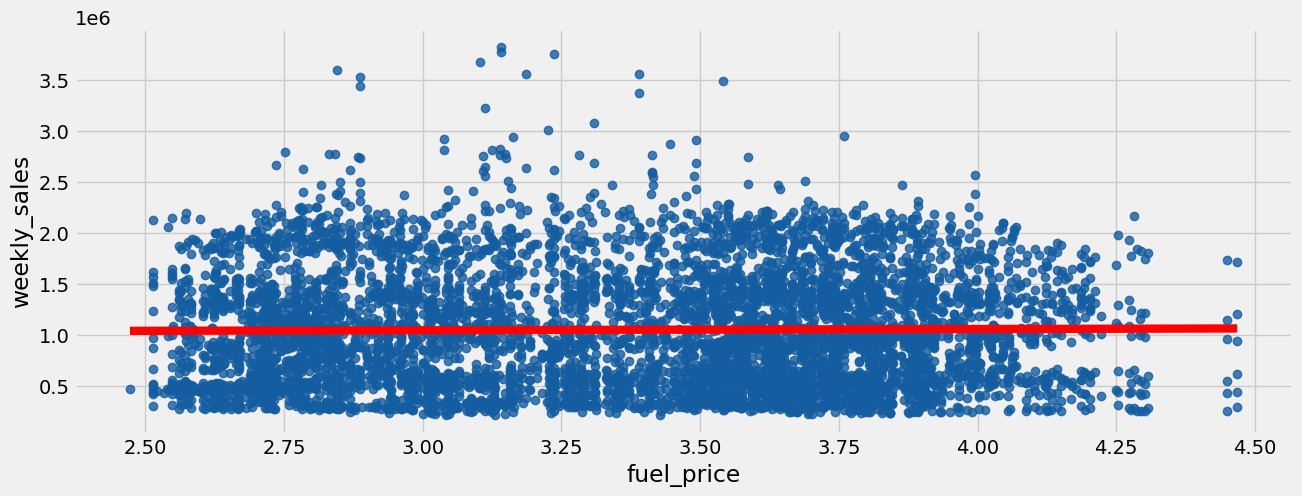

In [65]:
plt.figure(figsize = (14, 5))
sns.regplot(data = data, x = 'fuel_price', y = 'weekly_sales', color = '#145DA0', line_kws = {'color': 'red'})
plt.show()

**Conclusion:**
- Since the p-value is  >  0.1, the correlation between fuel price and weekly sales is not statistically significant.
- Fuel price does not seem like a good predictor of the weekly sales at all since the regression line is close to horizontal. Therefore, it's not a reliable variable.

<h3>Unemployment vs. Weekly Sales</h3>

In [66]:
# Let's calculate the Pearson Correlation Coefficient and P-value of 'unemployment' and 'weekly_sales':
pearson_coef, p_value = stats.pearsonr(data['unemployment'], data['weekly_sales'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.10617608965795423  with a P-value of P = 1.3448365210234661e-17


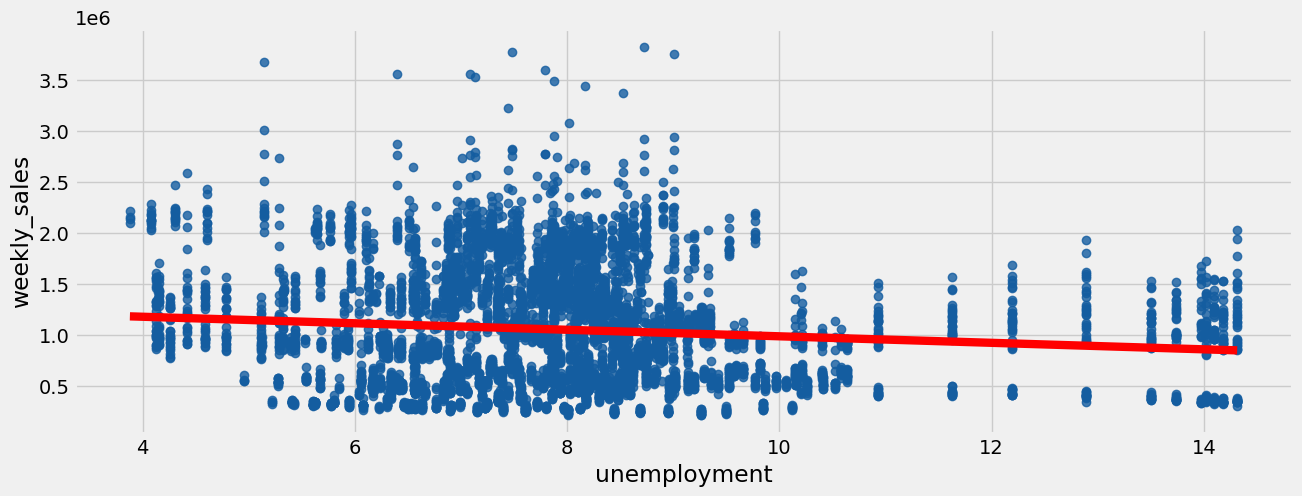

In [67]:
plt.figure(figsize = (14, 5))
sns.regplot(data = data, x = 'unemployment', y = 'weekly_sales', color = '#145DA0', line_kws = {'color': 'red'})
plt.show()

**Conclusion:**-
- Since the p-value is < 0.001, the correlation between unemployment and weekly sales is strong evidence that the correlation is significant.
- Unemployment seems like a good predictor of the weekly sales, The higher the unemployment rate, the lower the weekly sales.

<h3>CPI vs. Weekly Sales</h3>

In [68]:
# Let's calculate the Pearson Correlation Coefficient and P-value of cpi' and 'weekly_sales':
pearson_coef, p_value = stats.pearsonr(data['cpi'], data['weekly_sales'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.07263416204017623  with a P-value of P = 5.438292612176735e-09


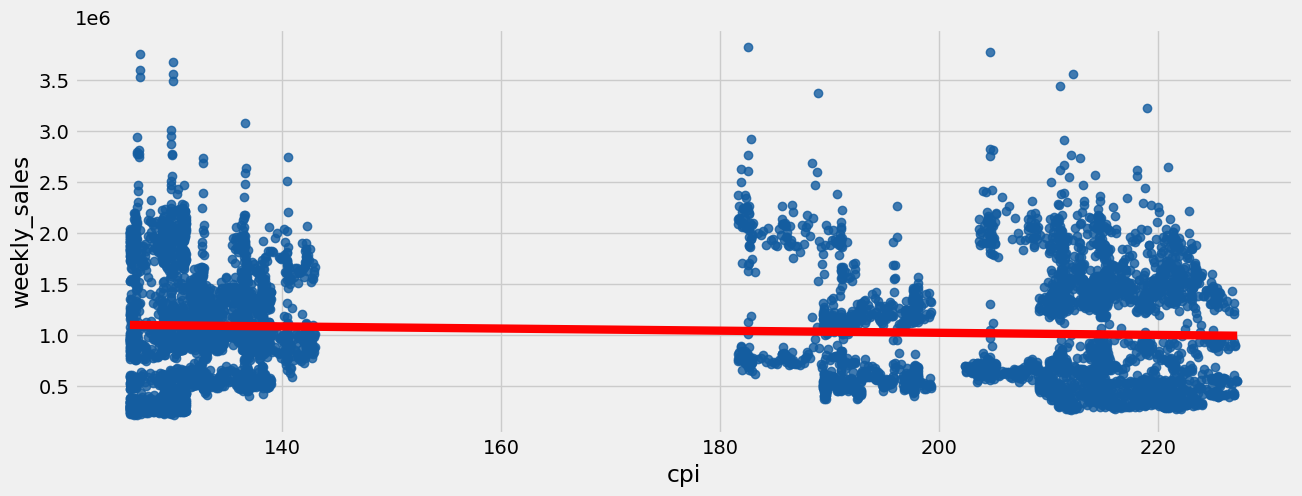

In [69]:
plt.figure(figsize = (14, 5))
sns.regplot(data = data, x = 'cpi', y = 'weekly_sales', color = '#145DA0', line_kws = {'color': 'red'})
plt.show()

**Conclusion:**
- Since the p-value is < 0.001, the correlation between CPI and weekly sales is strong evidence that the correlation is significant.

<h3>Temperature vs. Weekly Sales</h3>

In [70]:
# Let's calculate the Pearson Correlation Coefficient and P-value of temperature' and 'weekly_sales':
pearson_coef, p_value = stats.pearsonr(data['temperature'], data['weekly_sales'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.06381001317946956  with a P-value of P = 3.007647625833226e-07


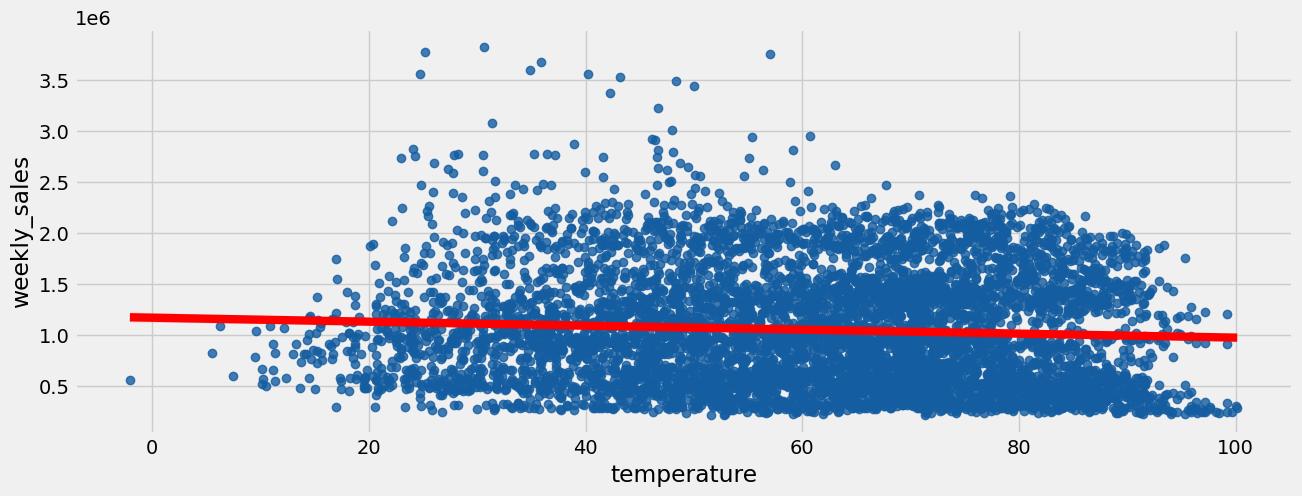

In [71]:
plt.figure(figsize = (14, 5))
sns.regplot(data = data, x = 'temperature', y = 'weekly_sales', color = '#145DA0', line_kws = {'color': 'red'})
plt.show()

**Conclusion:**
- Since the p-value is < 0.05, the correlation between temperature and weekly sales is moderate evidence that the correlation is significant.
- Temperature seems like a good predictor of the weekly sales, The higher the Temperature rate, the lower the weekly sales.

In [72]:
# Correlations with weekly sales
corr = data[['weekly_sales', 'temperature', 'fuel_price', 'cpi', 'unemployment']].corr()['weekly_sales'].sort_values(ascending = False)
corr = corr.to_frame()
corr.style.background_gradient(cmap="RdYlBu")

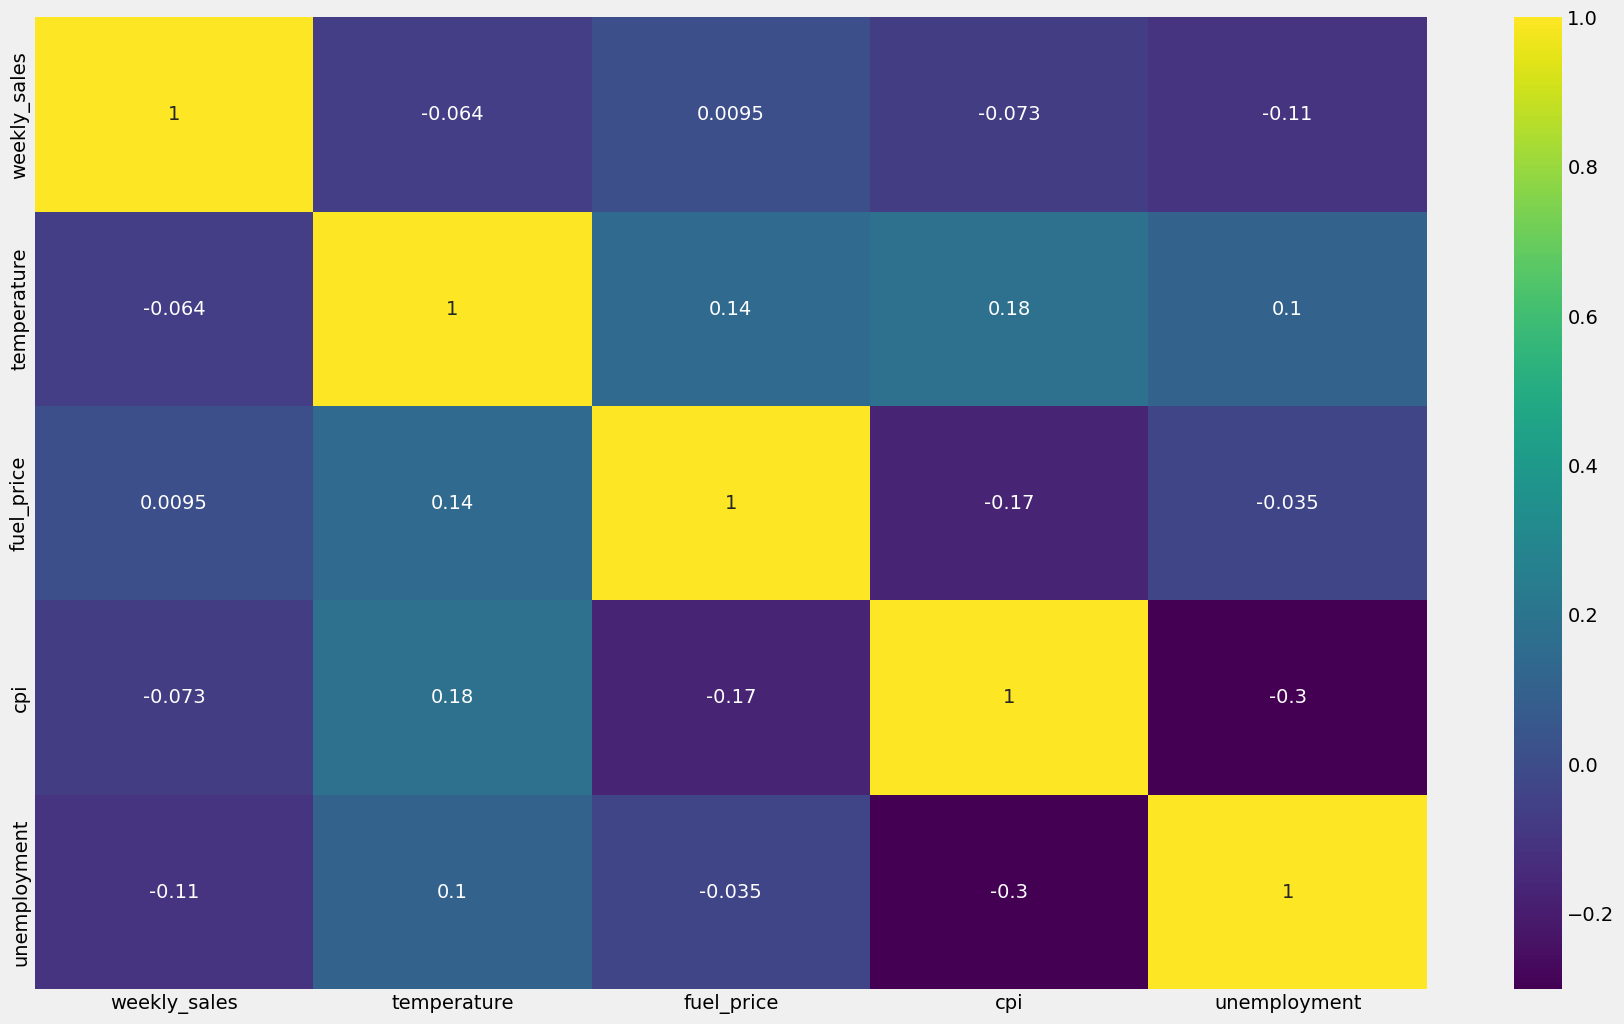

In [73]:
# Heatmap to explain the correlation between the features
plt.figure(figsize = (20, 12))
sns.heatmap(data[['weekly_sales', 'temperature', 'fuel_price', 'cpi', 'unemployment']].corr(), annot = True, cmap='viridis')
plt.show()

---

# Data Pre-processing

## 1. Taking A Copy Of The Data

In [77]:
data_copy = data.copy()

## 2. Dropping Unnecessary Columns

- Let's drop columns 'date', 'year' and drop columns 'quarter' and 'month'since there are the same columns as 'season' and 'month_name'.

- In the "day_of_week" column, Friday is the most frequent with 67.1% compared to other days, so the model will be biased to the class of Friday, so it prefers to drop this column to avoid underfitting.

In [78]:
data_copy.drop(['date', 'year', 'quarter', 'month', 'day_of_week'], axis = 1, inplace = True)

## 3. Data Type

In [83]:
# Check the data types
data_copy.dtypes

store            object
weekly_sales    float64
is_holiday       object
temperature     float64
fuel_price      float64
cpi             float64
unemployment    float64
season           object
month_name       object
week             object
dtype: object

In [84]:
# let's handle store and holiday columns as categorical features, so we should convert them into categories (objects).bb
data_copy['store'] = data_copy['store'].astype('object')
data_copy['is_holiday'] = data_copy['is_holiday'].astype('object')
data_copy['week'] = data_copy['week'].astype('object')

In [85]:
# Check the data types after convert
data_copy.dtypes

store            object
weekly_sales    float64
is_holiday       object
temperature     float64
fuel_price      float64
cpi             float64
unemployment    float64
season           object
month_name       object
week             object
dtype: object

## 4. Detecting And Removing The Outliers

0 fuel_price
1 temperature
2 cpi
3 unemployment


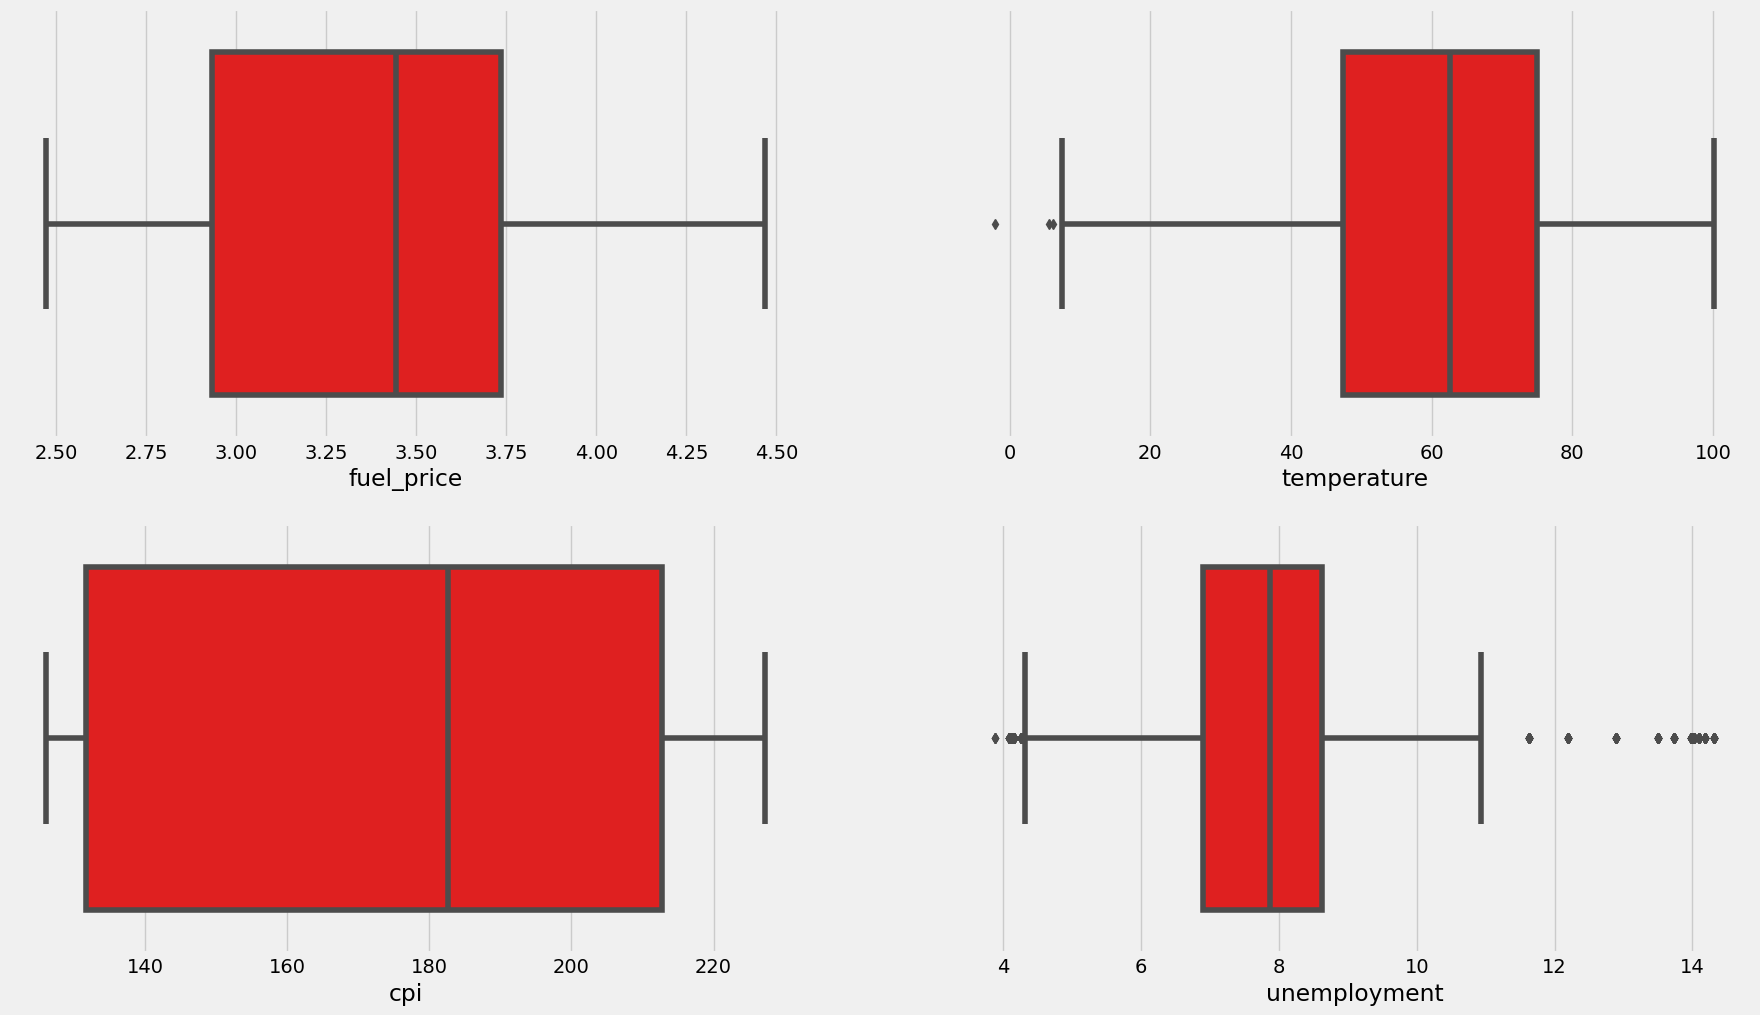

Number of data rows:  6435


In [86]:
cols = ['fuel_price', 'temperature', 'cpi', 'unemployment']
plt.figure(figsize=(20,18))
for i,col in enumerate(cols):
    print(i, col)
    plt.subplot(3,2,i+1)
    sns.boxplot(data_copy, x = col, color = 'red')
plt.show()

print('Number of data rows: ', data_copy.shape[0])

In [87]:
# Remove outliers from the temperature column
data_copy.drop(data_copy[data_copy['temperature'] < 7].index, axis = 0, inplace = True)

In [88]:
# Remove outliers from the unemployment column
data_copy.drop(data_copy[data_copy['unemployment'] < 4.4].index, axis = 0, inplace = True)
data_copy.drop(data_copy[data_copy['unemployment'] > 11].index, axis = 0, inplace = True)

0 temperature
1 fuel_price
2 cpi
3 unemployment


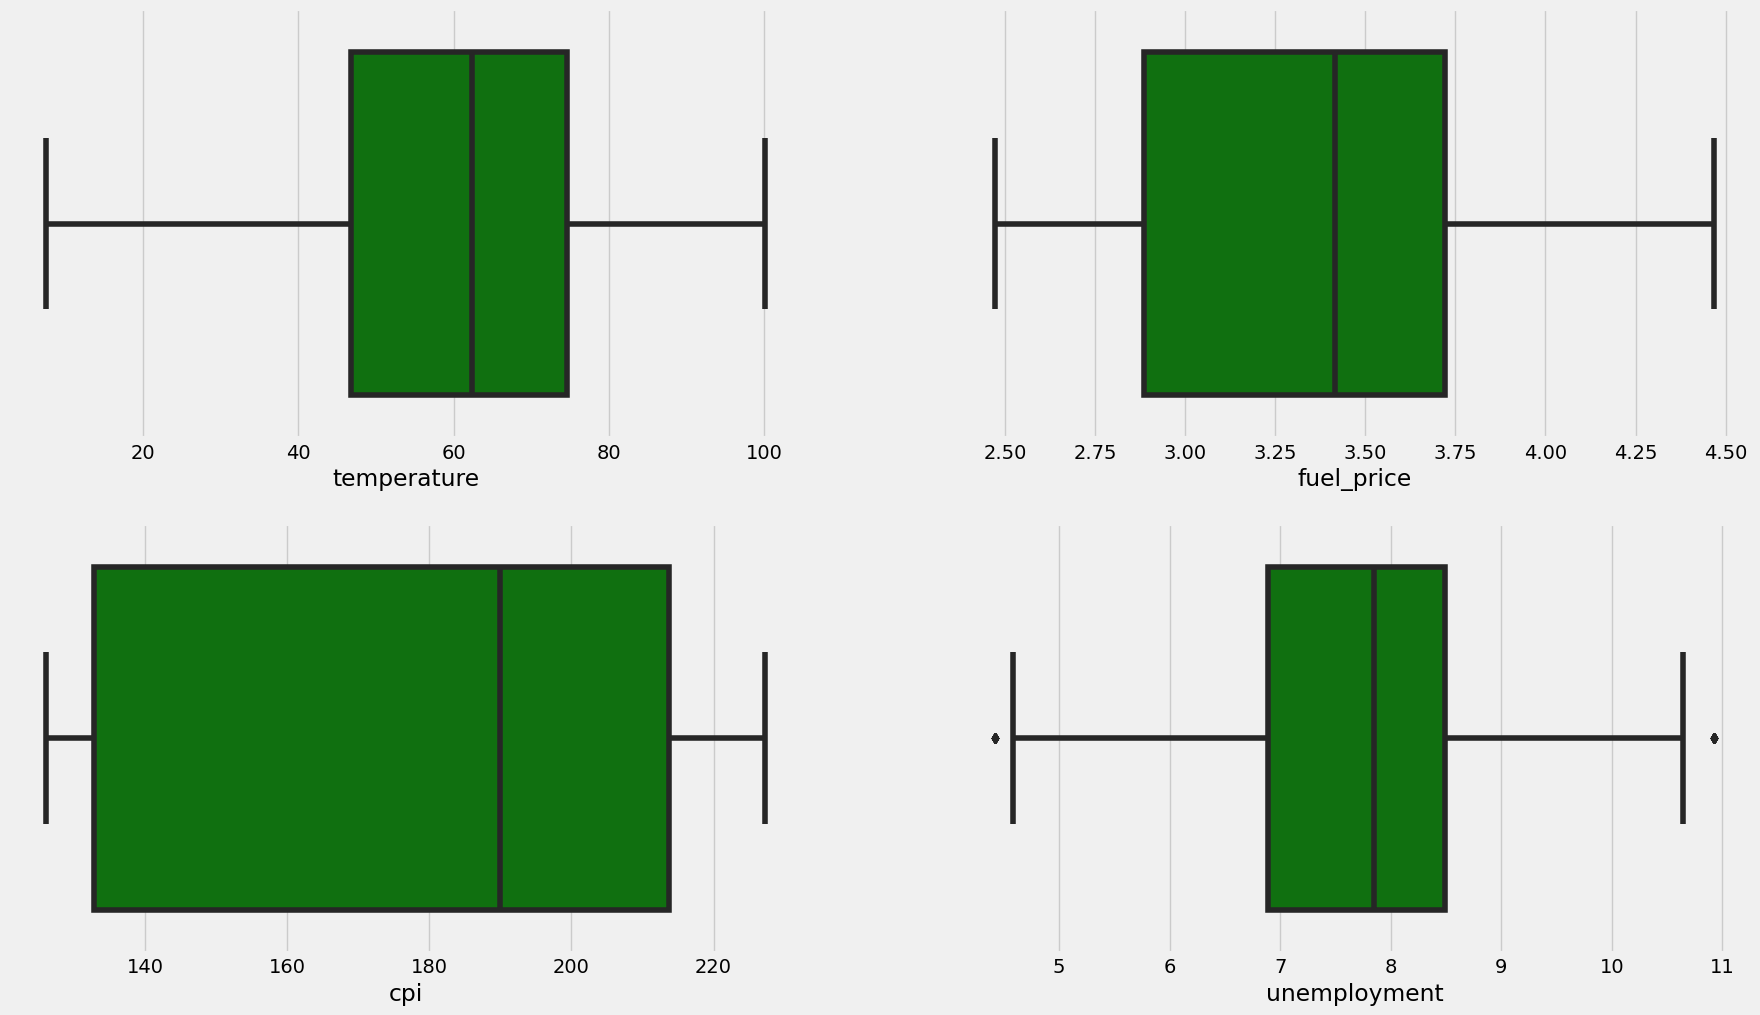

Number of data rows:  5938


In [89]:
cols = ['temperature', 'fuel_price', 'cpi', 'unemployment']
plt.figure(figsize=(20,18))
for i, col in enumerate(cols):
    print(i, col)
    plt.subplot(3,2,i+1)
    sns.boxplot(data_copy, x = col, color = 'g')
plt.show()

print('Number of data rows: ', data_copy.shape[0])

### 5. Splitting The Data To Training And Testing Data

In [90]:
X = data_copy.drop('weekly_sales', axis = 1)
y = data_copy['weekly_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [91]:
print('Shape of data      : ', X.shape)
print('Shape of train data: ', X_train.shape)
print('Shape of test data : ', X_test.shape)

Shape of data      :  (5938, 9)
Shape of train data:  (4750, 9)
Shape of test data :  (1188, 9)


### 6. Data Transformation

In [92]:
# Splitting the data into Numerical Features and Categorical Features
num_features = data_copy.select_dtypes('number').columns.to_list()
num_features.remove('weekly_sales')

cat_features = data_copy.select_dtypes('object').columns.to_list()

print(f'Numerical Features : {num_features}')
print(f'Categorical Features: {cat_features}')

Numerical Features : ['temperature', 'fuel_price', 'cpi', 'unemployment']
Categorical Features: ['store', 'is_holiday', 'season', 'month_name', 'week']


In [93]:
# data transformation pipeline
preprocessor = ColumnTransformer([
                                  ('num_features', StandardScaler(), num_features),
                                  ('cat_features', BinaryEncoder(), cat_features),
                                ])

# Fitting the training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num_features', StandardScaler(),
                                 ['temperature', 'fuel_price', 'cpi',
                                  'unemployment']),
                                ('cat_features', BinaryEncoder(),
                                 ['store', 'is_holiday', 'season', 'month_name',
                                  'week'])])

In [94]:
# Transform the training data
X_train_transformed = preprocessor.transform(X_train)

# Transform the testing data
X_test_transformed = preprocessor.transform(X_test)

---

# Modeling

In [95]:
def model_evaluation(estimator, Training_Testing, X, y):

    ''' This function is used to evaluate the model through RMSE and R2'''

    # Y predict of X train or X test
    predict_data = estimator.predict(X)

    print(f'{Training_Testing} Accuracy: \n')
    print(f'-> Root Mean Squared Error: {round(np.sqrt(mean_squared_error(y, predict_data)), 2)}')
    print(f'-> R-Squere score Training: {round(r2_score(y, predict_data) * 100, 2)} % \n')

In [96]:
def Distribution_Plot(estimator, Training_Testing, X, y, Title):

    """This function is used to perform some model evaluation using training and testing data \
    by plotting the distribution of the actual and predicted values of the training or testing data."""

    # Y predict of X train or X test
    yhat = estimator.predict(X)

    plt.figure(figsize=(14, 6))
    ax1 = sns.distplot(y, hist = False, color = "b", label = f'Actual Values ({Training_Testing})')
    ax2 = sns.distplot(yhat, hist = False, color = "r", label = f'Predicted Values ({Training_Testing})', ax = ax1)
    plt.title(Title, size = 18)
    plt.legend()
    plt.show()

In [97]:
def cross_validation_score(estimator, X_train, y_train, score = 'r2', n = 5):

    '''This function is to validate the model'''


    validate = cross_val_score(estimator, X_train, y_train, scoring = score, cv = n)

    print(f'Cross Validation Scores: {validate} \n')
    print(f'Mean of Scores: {round(validate.mean() * 100, 2)} % \n')
    print(f'Standard Deviation of Scores: {validate.std()}')

In [98]:
def hyperparameter_tunning(estimator, X_train, y_train, param_grid, score = 'r2', n = 5):

    '''This function is used to find the best set of hyperparameters for the model to optimize its performance'''


    # Perform grid search
    grid_search = GridSearchCV(estimator = estimator,
                               param_grid = param_grid,
                               scoring = score,
                               cv = n)

    # Fit the data
    grid_search.fit(X_train,y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Print the best parameters and score
    print(f'Best parameters: {best_params} \n')
    print(f'Best score: {best_score}')

    # best estimator
    best_estimator = grid_search.best_estimator_

    return best_estimator

## 1. Linear Regression

### 1.1. Creating The Model

In [99]:
# Linear Regression Model
LR = LinearRegression()

# Fitting the data
LR.fit(X_train_transformed, y_train)

LinearRegression()

### 1.2. Evaluating The Model (Training)

In [100]:
# Training Accuracy
model_evaluation(LR, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 522051.03
-> R-Squere score Training: 16.11 % 



</h4>Let's examine the distribution of the predicted values of the training data</h4>

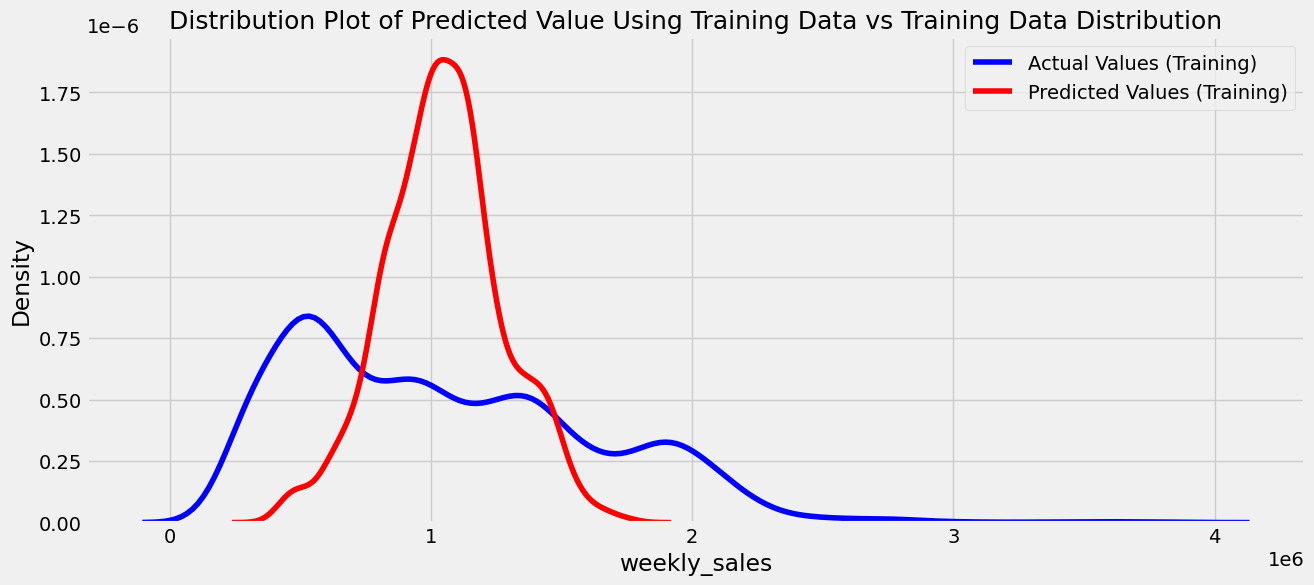

In [101]:
# Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(LR, 'Training', X_train_transformed, y_train, Title)

**Conclusion:**
- Since there are no linear correlations between variables and targets, The model seems to be not doing well in learning from the training dataset, so we need to increase the complexity of this model. let's do Polynomial Features for the data before modeling.

### 1.3. Tuning The Model

In [102]:
# Polynomial Regression Model
LR_pipe = Pipeline([('poly_feat', PolynomialFeatures()),
                    ('lin_reg', LinearRegression())])

# Define the parameter grid to search
param_grid = {'poly_feat__degree': [2, 3, 4]}

best_estimator = hyperparameter_tunning(LR_pipe, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best parameters: {'poly_feat__degree': 3} 

Best score: 0.961587247259336


In [103]:
# Linear Regression Model after tuning
poly_reg = best_estimator

### 1.4. Evaluating The Model  After Tuning

In [104]:
# Training Accuracy Afer tuning
model_evaluation(poly_reg, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 67122.63
-> R-Squere score Training: 98.61 % 



</h4>Let's examine the distribution of the predicted values of the training data after tuning</h4>

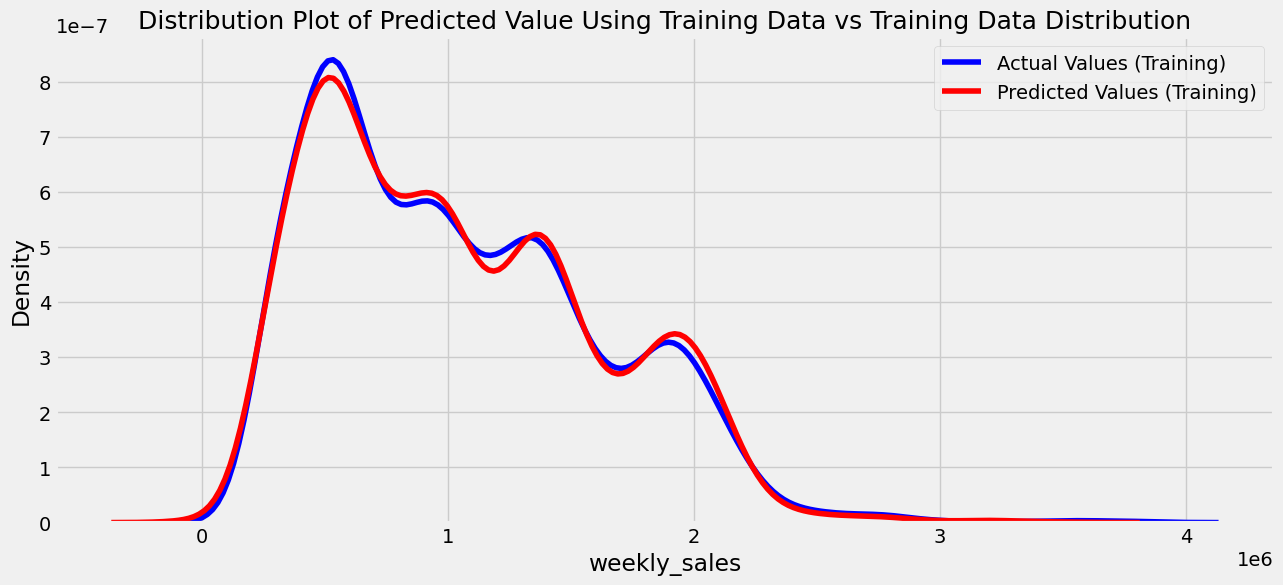

In [105]:
# Figure 2: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(poly_reg, 'Training', X_train_transformed, y_train, Title)

**Conclusion:**
- After applying Polynomial Features to the training data, The model seems to have improved more in learning from the training dataset.


### 1.5. Cross Validation Score

In [106]:
cross_validation_score(poly_reg, X_train_transformed, y_train)

Cross Validation Scores: [0.9601431  0.96254509 0.95954481 0.96750533 0.95819791] 

Mean of Scores: 96.16 % 

Standard Deviation of Scores: 0.003276761961364399


### 1.6. Testing The Model

In [107]:
# Testing Accuracy
model_evaluation(poly_reg, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 101730.35
-> R-Squere score Training: 96.84 % 



</h4>Let's examine the distribution of the predicted values of the test data.</h4>

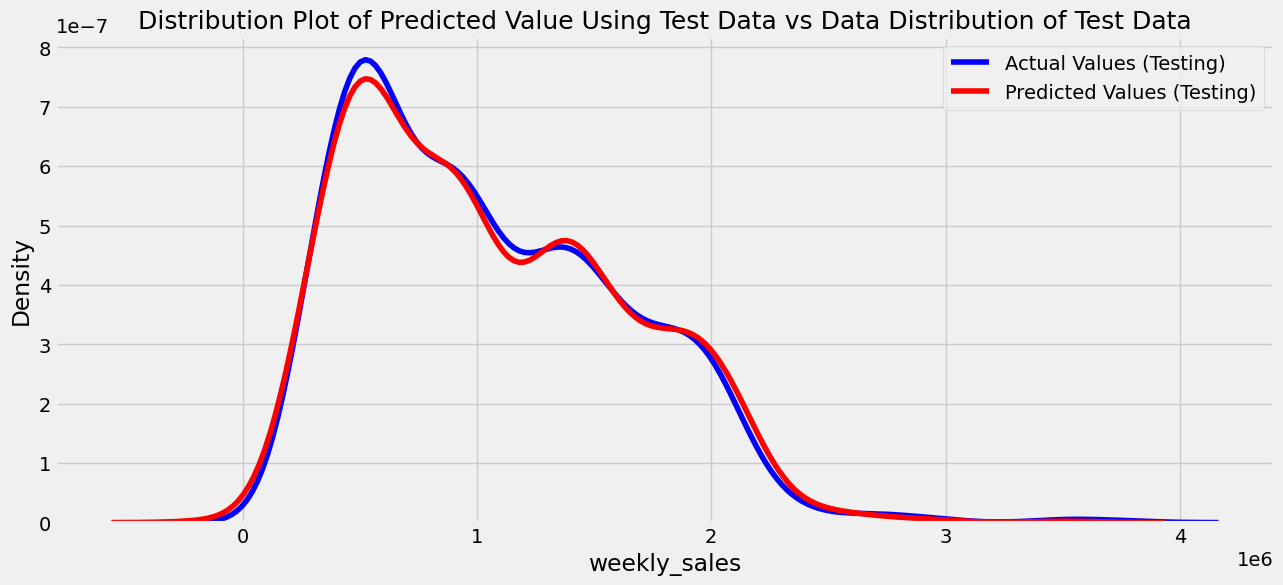

In [108]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(poly_reg, 'Testing', X_test_transformed, y_test, Title)

**Conclusion:**
- After testing the polynomial regression model, it became clear that the model had learned sufficiently, as its accuracy was 96.84 %.

## 2. KNN Regressor

### 2.1. Creating The Model

In [109]:
# KNN Regression Model
KNN_Reg = KNeighborsRegressor(n_neighbors = 5)

# Fitting the training data
KNN_Reg.fit(X_train_transformed, y_train)

KNeighborsRegressor()

### 2.2. Evaluating The Model (Training)

In [110]:
# Training Accuracy
model_evaluation(KNN_Reg, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 358918.31
-> R-Squere score Training: 60.35 % 



<b4>Let's examine the distribution of the predicted values of the training data<b4>

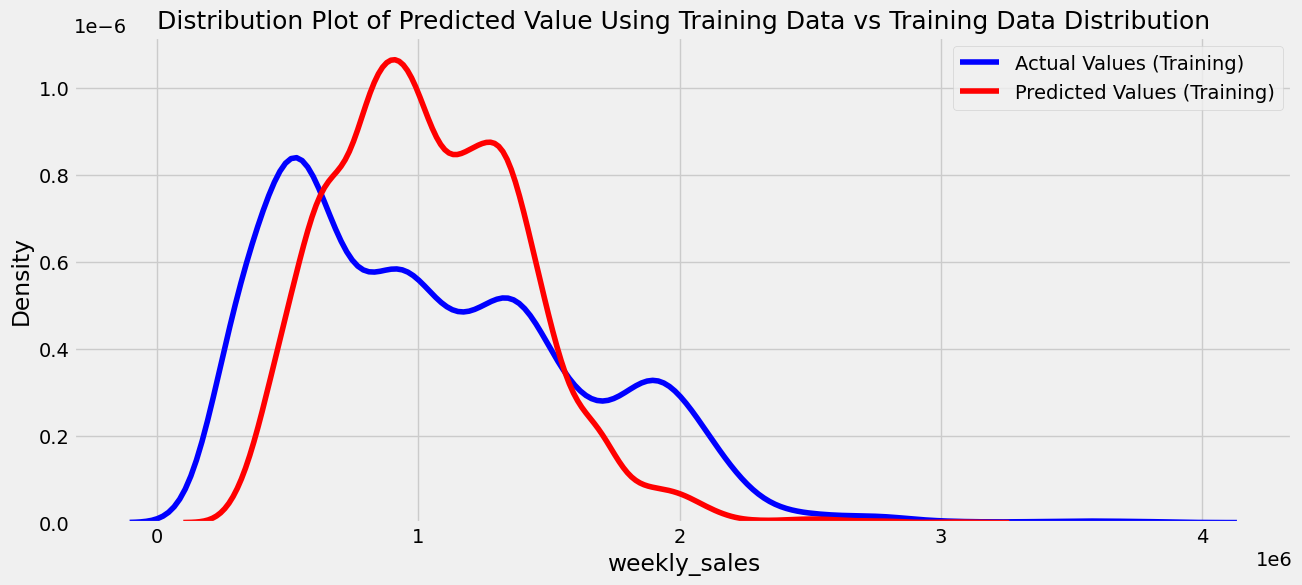

In [111]:
# Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(KNN_Reg, 'Training', X_train_transformed, y_train, Title)

**Conclusion:**
- The model seems to be doing not bad in learning from the training dataset.

### 2.3. Tuning The Model

In [112]:
# Define the parameter grid to search
param_grid = {'n_neighbors': [1, 3, 5, 7, 8, 9, 11, 13]}

best_estimator = hyperparameter_tunning(KNN_Reg, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best_KNN = best_estimator

Best parameters: {'n_neighbors': 13} 

Best score: 0.42320054785291283


### 2.4. Evaluating The Model After Tuning

In [113]:
# Training Accuracy Afer tuning
model_evaluation(Best_KNN, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 395434.36
-> R-Squere score Training: 51.87 % 



<b4>Let's examine the distribution of the predicted values of the training data after tuning<b4>

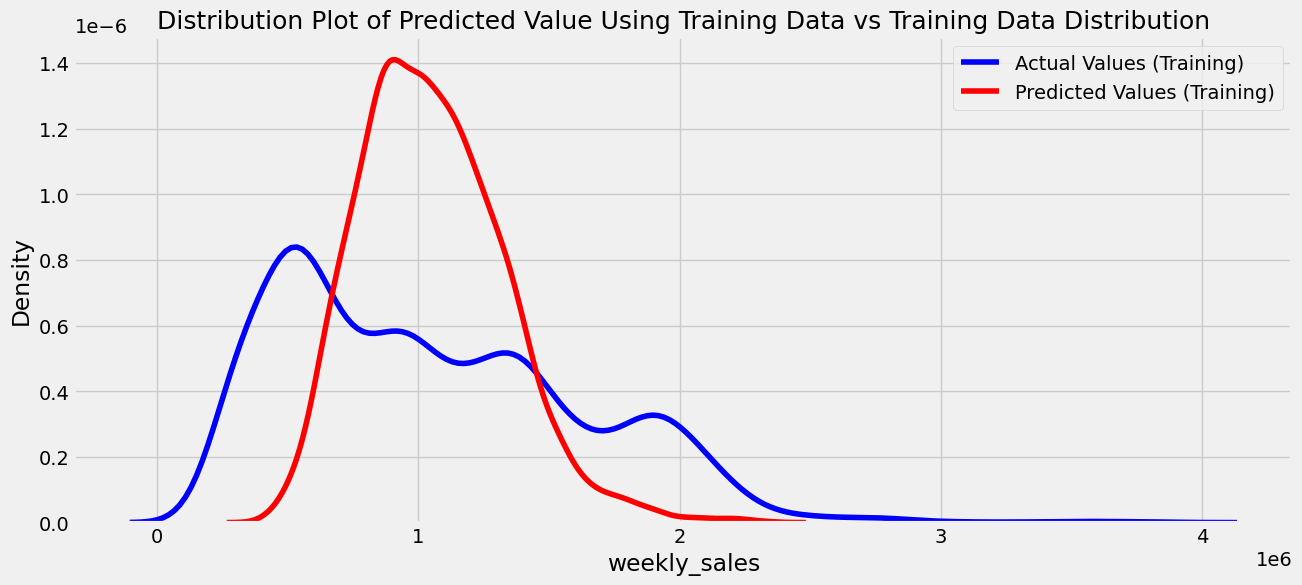

In [114]:
# Figure 2: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(Best_KNN, 'Training', X_train_transformed, y_train, Title)

**Conclusion:**
- After tuning the hyperparameter of n_neighbors, The model seems to have improved a little in learning from the training dataset.

### 2.5. Cross Validation Score

In [115]:
cross_validation_score(Best_KNN, X_train_transformed, y_train, n = 10)

Cross Validation Scores: [0.42269564 0.38167557 0.40153214 0.45908764 0.42543618 0.41456613
 0.41172563 0.433573   0.43025631 0.46477738] 

Mean of Scores: 42.45 % 

Standard Deviation of Scores: 0.023582767692979376


### 2.6. Testing The Model

In [116]:
# Testing Accuracy
model_evaluation(Best_KNN, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 422689.74
-> R-Squere score Training: 45.37 % 



</h4>Let's examine the distribution of the predicted values of the test data.</h4>

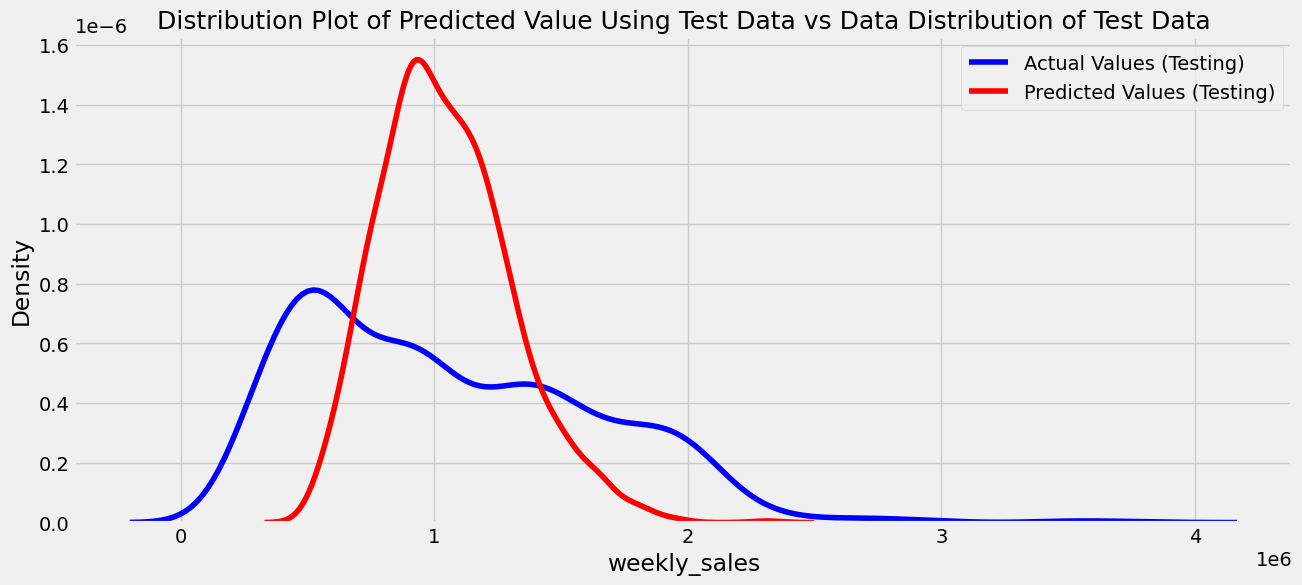

In [117]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(Best_KNN, 'Testing', X_test_transformed, y_test, Title)

**Conclusion:**
- After testing the KNN Regressor model, it became clear that it is a bad model with an accuracy of 45.37 % in comparison to the above algorithm we used (Linear Regression).

## 3. Decision Tree Regressor

### 3.1. Creating The Model

In [118]:
# Decision Tree regressor Model
tree = DecisionTreeRegressor()

# Fitting the training data
tree.fit(X_train_transformed, y_train)

DecisionTreeRegressor()

### 3.2. Evaluating The Model (Training)

In [119]:
# Training Accuracy
model_evaluation(tree, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 0.0
-> R-Squere score Training: 100.0 % 



<b4>Let's examine the distribution of the predicted values of the training data<b4>

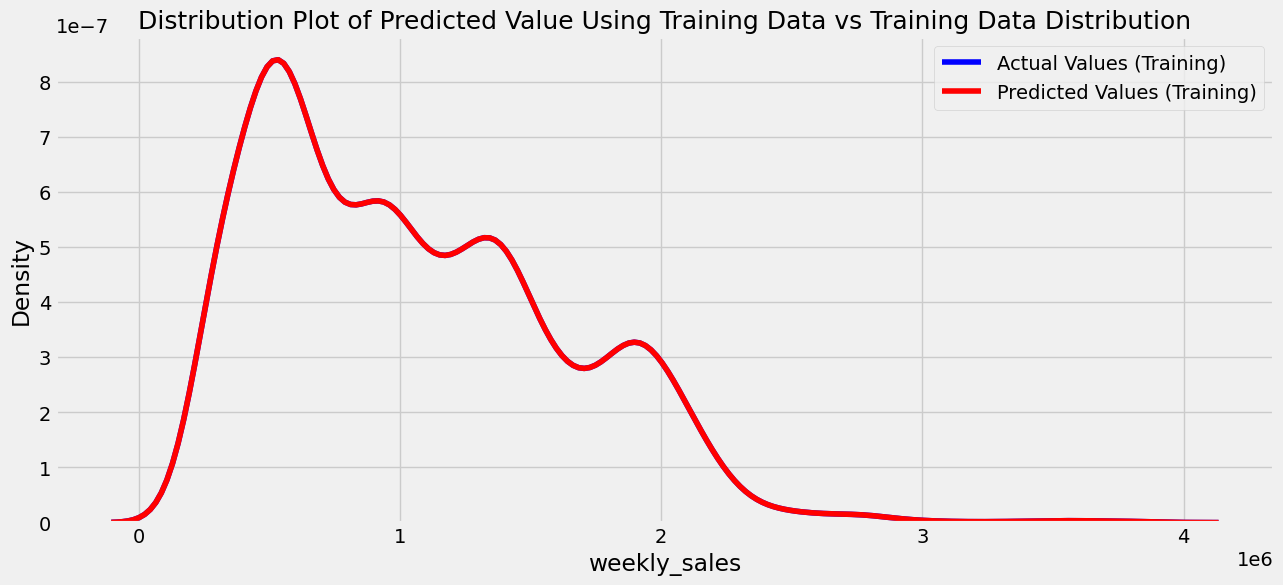

In [120]:
# Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(tree, 'Training', X_train_transformed, y_train, Title)

**Conclusion:**

- The model has overfitting, so let's improve it by tuning the hyperparameters..

### 3.3. Tuning The Model

In [121]:
# Define the parameter grid to search
param_grid = {'max_depth': np.arange(2, 15),
              'min_samples_split': [10, 20, 30, 40, 50, 100, 200, 300]}

best_estimator = hyperparameter_tunning(tree, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best_Tree = best_estimator

Best parameters: {'max_depth': 10, 'min_samples_split': 40} 

Best score: 0.9235353051746534


### 3.4. Evaluating The Model After Tuning

In [122]:
# Training Accuracy Afer tuning
model_evaluation(Best_Tree, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 132317.2
-> R-Squere score Training: 94.61 % 



<b4>Let's examine the distribution of the predicted values of the training data after tuning<b4>

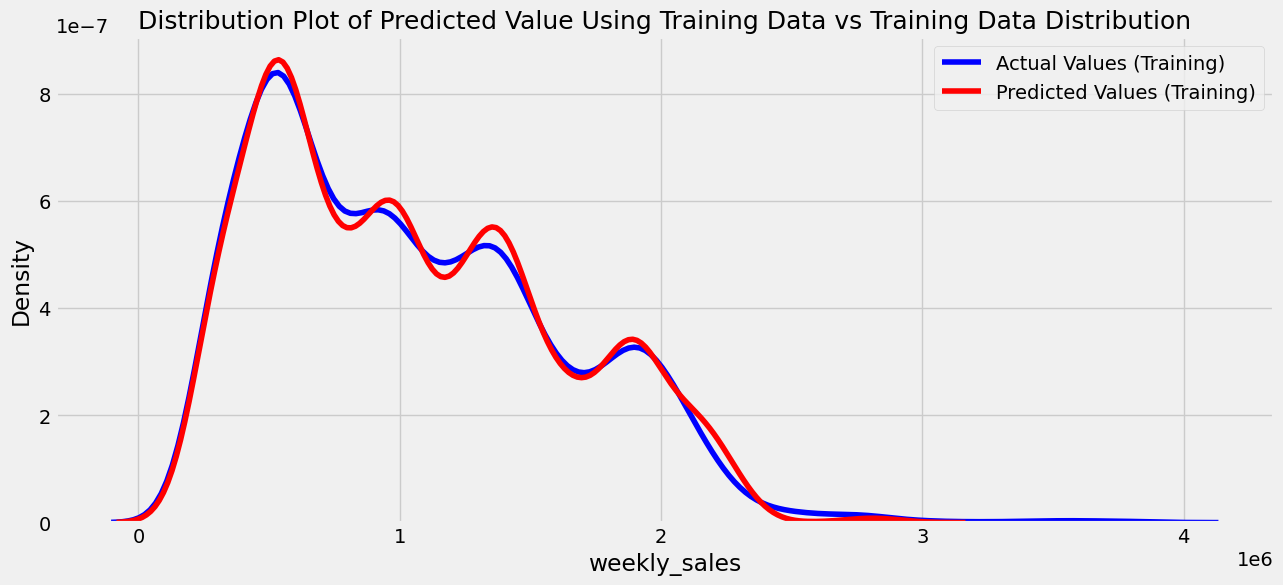

In [123]:
# Figure 2: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(Best_Tree, 'Training', X_train_transformed, y_train, Title)

**Conclusion:**
- After tuning the hyperparameter of max_depth and min_samples_split, The model seems to have improved well in learning from the training dataset.

### 3.5. Cross Validation Score

In [124]:
cross_validation_score(Best_Tree, X_train_transformed, y_train, n = 10)

Cross Validation Scores: [0.92419682 0.92596737 0.93834907 0.88450633 0.92063419 0.92607608
 0.94836973 0.92932267 0.88736981 0.92506667] 

Mean of Scores: 92.1 % 

Standard Deviation of Scores: 0.019129733609356995


### 3.6. Testing The Model

In [125]:
# Testing Accuracy
model_evaluation(Best_Tree, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 152249.35
-> R-Squere score Training: 92.91 % 



</h4>Let's examine the distribution of the predicted values of the test data.</h4>

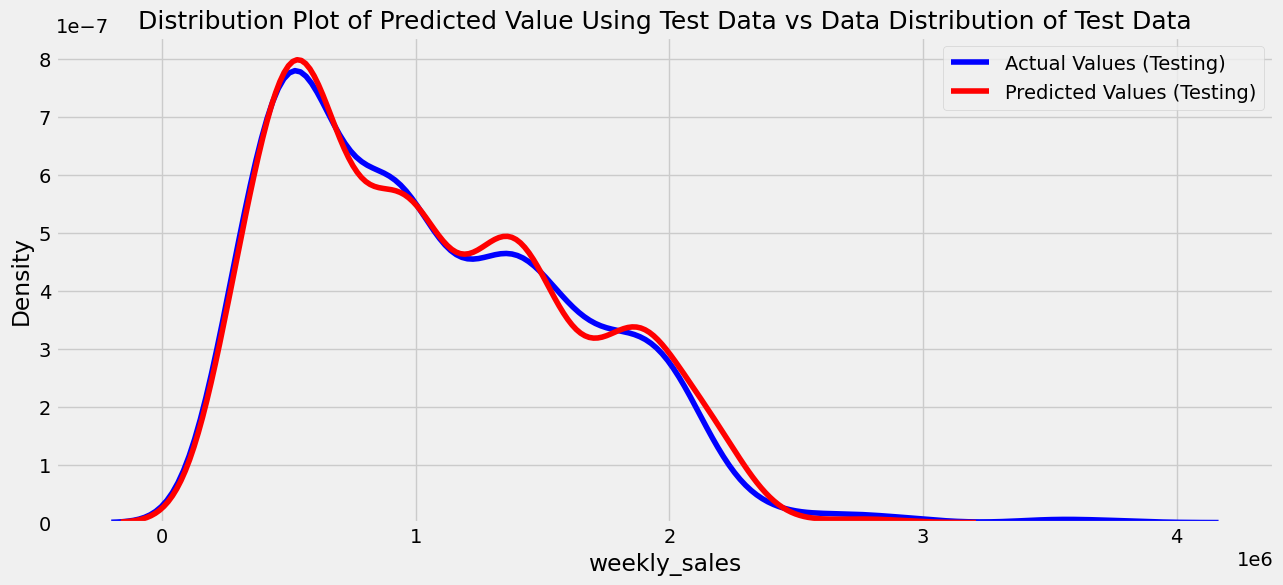

In [126]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(Best_Tree, 'Testing', X_test_transformed, y_test, Title)

**Conclusion:**
- After testing the Decision Tree Regressor model, it became clear that it is the best model with an accuracy of 92.94 % compared to the above algorithms we used (KNN).

## 4. Random Forest Regressor (Bagging)

### 4.1. Creating The Model

In [127]:
# Random Forest regressor Model
rf = RandomForestRegressor()

# Fitting the training data
rf.fit(X_train_transformed, y_train)

RandomForestRegressor()

### 4.2. Evaluating The Model (Training)

In [128]:
# Training Accuracy
model_evaluation(rf, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 50354.97
-> R-Squere score Training: 99.22 % 



<b4>Let's examine the distribution of the predicted values of the training data<b4>

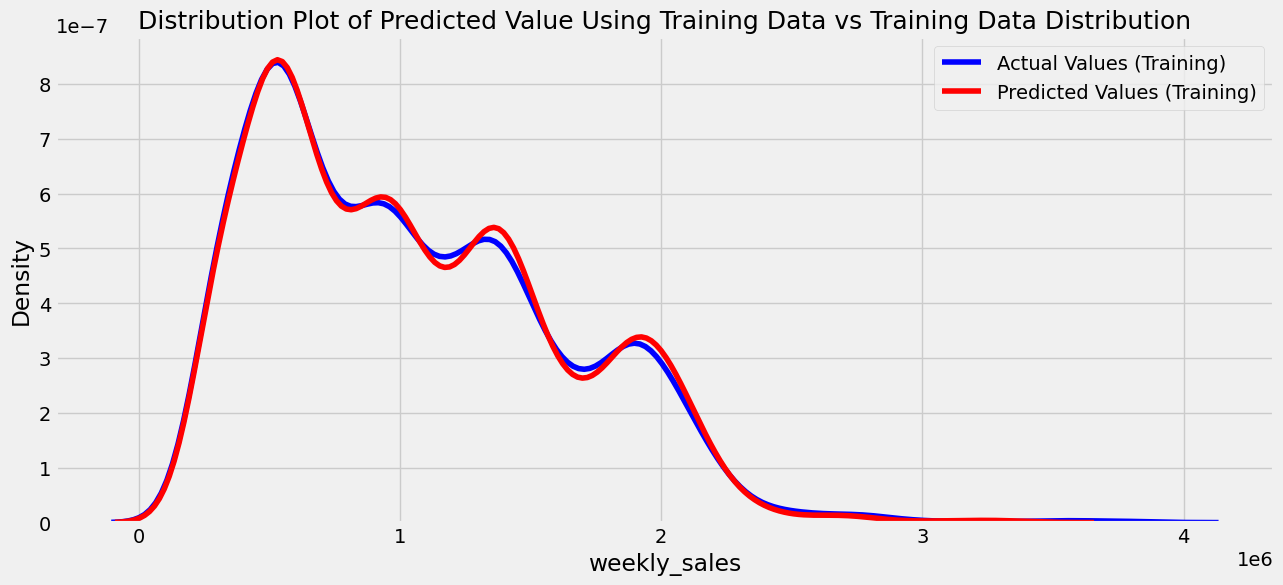

In [129]:
# Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(rf, 'Training', X_train_transformed, y_train, Title)

**Conclusion:**

- Has the model been overfitted?! let's be sure of that by doing a cross-validation score.

### 4.3. Cross Validation Score

In [130]:
cross_validation_score(rf, X_train_transformed, y_train, n = 10)

Cross Validation Scores: [0.94761678 0.94564217 0.96041093 0.89965504 0.92166336 0.94774124
 0.96444412 0.9480986  0.92977235 0.94161876] 

Mean of Scores: 94.07 % 

Standard Deviation of Scores: 0.01815549009138287


**Conclusion:**

- After doing a cross-validation score, we see the model has trained very well.

### 4.4. Testing The Model

In [131]:
# Testing Accuracy
model_evaluation(rf, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 127181.18
-> R-Squere score Training: 95.05 % 



</h4>Let's examine the distribution of the predicted values of the test data.</h4>

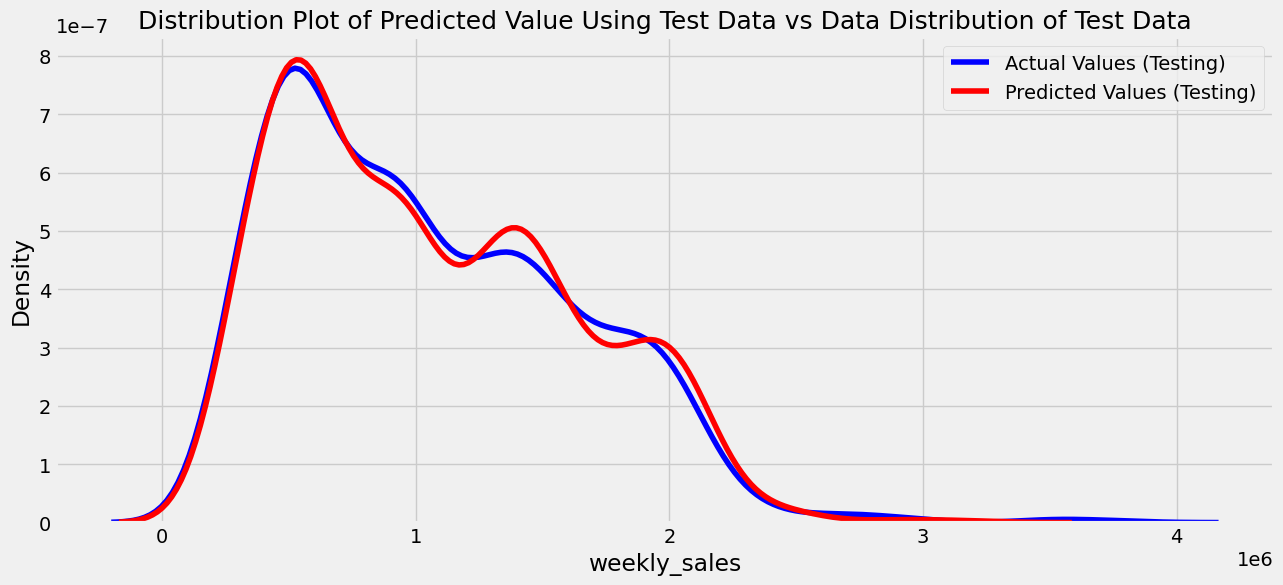

In [132]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(rf, 'Testing', X_test_transformed, y_test, Title)

**Conclusion:**

- After testing the Random Forest Regressor model, it became clear that it is the best model with an accuracy of 94.76 % compared to the above algorithms we used (e.g. KNN, and Decision Tree Regressor).

---

<h1>Decision Making: Determining a Good Model Fit</h1>

<p>Now that we have visualized the different models, and generated the R-squared and MSE values for the fits, how do we determine a good model fit?
<ul>
    <li><i>What is a good R-squared value?</i></li>
</ul>
</p>

<p>When comparing models, <b>the model with the higher R-squared value is a better fit</b> for the data.
<ul>
    <li><i>What is a good MSE?</i></li>
</ul>
</p>

<p>When comparing models, <b>the model with the smallest MSE value is a better fit</b> for the data.</p>

<h4>Let's take a look at the values for the different models.</h4>
<p>Linear Regression:
<ul>
    <li>R-squared: 96.84 %</li>
    <li>RMSE: 101730.35</li>
</ul>
</p>

<p>KNN Regressor:
<ul>
    <li>R-squared: 45.37 %</li>
    <li>RMSE: 422689.74</li>
</ul>
</p>

<p>Decision Tree Regressor:
<ul>
    <li>R-squared: 92.94 %</li>
    <li>RMSE: 151915.04</li>
</ul>
</p>

<p>Random Forest Regressor:
<ul>
    <li>R-squared: 94.76 %</li>
    <li>RMSE: 130846.43</li>
</ul>
</p>


<h1>Conclusions</h1>

- <p>Sales tend to be higher in Summer.</p>

- <p>The rate of sales on holidays is higher than on other days.</p>

- <p>There is a high variance in weekly sales from one store to another.</p>

- <p>Sales are affected by the unemployment rate, so the higher the unemployment rate, the lower the sales.</p>

- <p>Comparing these four models, we conclude that <b>The Linear Regression Model</b> is the best model with an accuracy of  96.84 % to be able to predict weekly sales from our dataset.</p>


---